## Uncertainty in Explanations via Input Perturbation (Vision)

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers, models
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
import cv2

In [2]:
#import sys
#sys.path.append('./xplique/')
from xplique.attributions import (Lime, Saliency, GradientInput, IntegratedGradients, GuidedBackprop,
                                  SmoothGrad, SquareGrad, VarGrad, Occlusion, Rise,
                                  KernelShap, DeconvNet)

In [3]:
# Load and Prepare MNIST Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1]
x_train = gray2rgb(x_train) # for RGB
x_test = gray2rgb(x_test)
#x_train = x_train[..., np.newaxis] # for grayscale
#x_test = x_test[..., np.newaxis]

In [13]:
# Whether to train a model or load a pretrained one
train_model = False
model_path = './models/cnn_mnist.h5'

In [14]:
if train_model:
    # Build and train a simple CNN
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)), # RGB
        #layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)), # grayscale
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax'),
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=2, batch_size=64, validation_split=0.25)
    model.save(model_path)
else:
    model = tf.keras.models.load_model(model_path)
# XAI methods require removal of Softmax
model.layers[-1].activation = tf.keras.activations.linear

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

### Example Computation

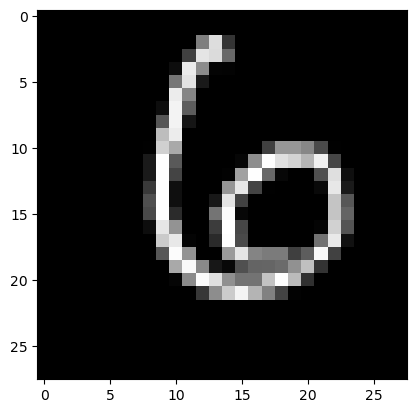

In [54]:
# Explain sample prediction
sample_index = 100
sample_image, sample_label = x_test[sample_index], y_test[sample_index]
sample_image = np.expand_dims(sample_image, axis=0)
sample_label = np.expand_dims(sample_label, axis=0)
sample_image.shape
plt.imshow(sample_image.squeeze());

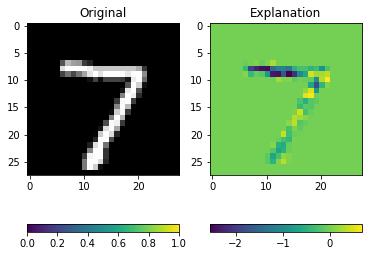

In [10]:
#explainer = Saliency(model)
#explainer = GradientInput(model)
explainer = IntegratedGradients(model, steps=80, batch_size=1)
#explainer = SmoothGrad(model, nb_samples=80, batch_size=1)
#explainer = SquareGrad(model, nb_samples=80, batch_size=1)
#explainer = DeconvNet(model)
#explainer = VarGrad(model, nb_samples=80, batch_size=1)
    #explainer = Occlusion(model, patch_size=10, patch_stride=5)
    #explainer = Rise(model, nb_samples=80)
#explainer = Lime(model, nb_samples = 80, batch_size=1)
#explainer = KernelShap(model, nb_samples = 80, batch_size=1)

explanation = explainer.explain(sample_image, sample_label)

# Display explanation
plt.figure(figsize=(6,6))
plt.subplot(121)
plt.imshow(sample_image.squeeze()) # shape (1, 28, 28, 3)
plt.title("Original")
plt.colorbar(orientation='horizontal')
plt.subplot(122)
plt.imshow(explanation[0]) # shape (1, 28, 28)
plt.title("Explanation")
plt.colorbar(orientation='horizontal')
plt.show()

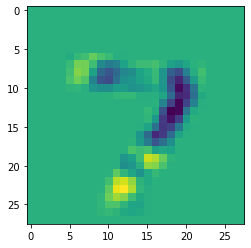

In [7]:
gauss_exp = cv2.GaussianBlur(explanation[0].numpy(), (3,3), 6)
#gauss_exp = cv2.GaussianBlur(explanation[0].numpy(), (3,3), 1)
plt.imshow(gauss_exp);

In [9]:
# Compute derivative of explanation w.r.t input via FDM
# Note: takes up to 5 minutes for Integrated Grads, SmoothGrad
dx = 1e-3 #1e-4
sample_image = sample_image.squeeze()
n = np.product(np.shape(sample_image))
m = np.product(np.shape(explanation))
h, w = sample_image.shape[0], sample_image.shape[1]
derivative_e_x = np.zeros((m, n))

# For every pixel perturbation, we get a new column in the Jacobian
for i in range(h):
    for j in range(w):
        # Perturb pixel (i, j)
        perturbed_image = np.copy(sample_image)
        perturbed_image[i, j] += dx
        perturbed_image = np.clip(perturbed_image, 0, 1)  # Keep within valid range

        # Compute explanation for perturbed image
        perturbed_explanation = explainer.explain(np.expand_dims(perturbed_image, axis=[0,3]), sample_label)

        # Compute finite difference gradient
        #derivative_2d = (perturbed_explanation[0] - explanation[0]) / dx
        gauss_perturbed_exp = cv2.GaussianBlur(perturbed_explanation[0].numpy(), (3,3), 6) # tested sigmas: 6 and 1
        #derivative_2d = (gauss_perturbed_exp - gauss_exp) / dx

        # Normalize the explanations to [0, 1]
        normalized_explanation = (gauss_exp - gauss_exp.min()) / (gauss_exp.max() - gauss_exp.min())
        normalized_perturbed_explanation = (gauss_perturbed_exp - gauss_perturbed_exp.min()) / (gauss_perturbed_exp.max() - gauss_perturbed_exp.min())
        derivative_2d = (normalized_perturbed_explanation - normalized_explanation) / dx

        # Fill out the corresponding column in the jacobian
        flat_ind = i * w + j
        derivative_e_x[:, flat_ind] = derivative_2d.reshape(m, )

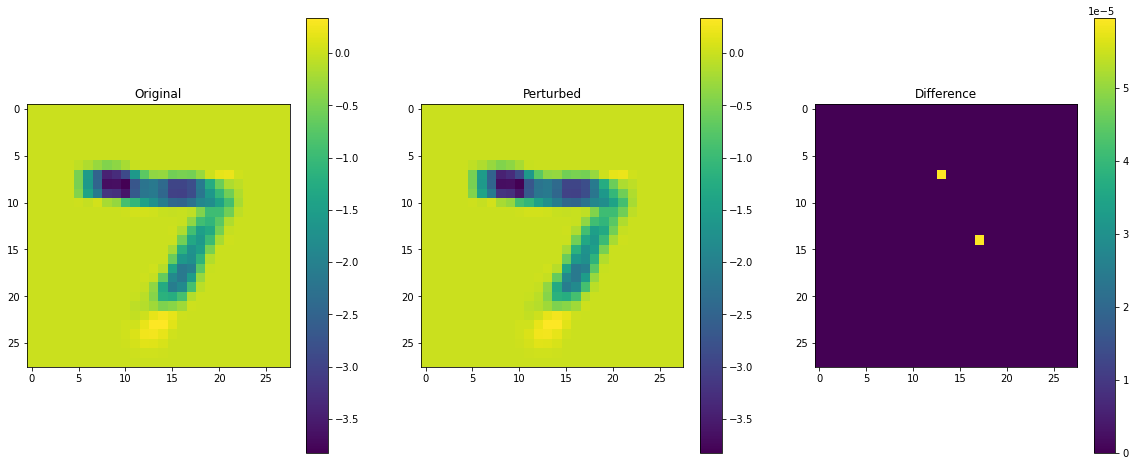

In [10]:
# Display explanation
plt.figure(figsize=(20,8))
plt.subplot(131)
plt.imshow(gauss_exp) # shape (1, 28, 28, 1)
plt.title("Original")
plt.colorbar()
plt.subplot(132)
plt.imshow(gauss_perturbed_exp) # shape (1, 28, 28)
plt.title("Perturbed")
plt.colorbar()
plt.subplot(133)
plt.imshow(np.abs(normalized_perturbed_explanation - normalized_explanation) / dx) # shape (1, 28, 28)
plt.title("Difference")
plt.colorbar()
plt.show()

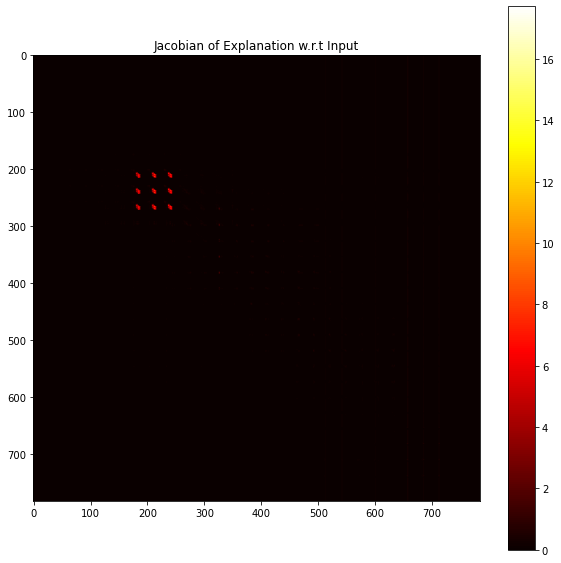

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(derivative_e_x), cmap='hot')
plt.title("Jacobian of Explanation w.r.t Input")
plt.colorbar()
plt.show()

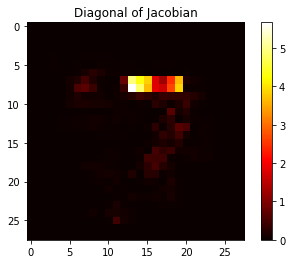

In [12]:
plt.imshow(np.abs(np.diag(derivative_e_x).reshape(h,w)), cmap='hot')
plt.title("Diagonal of Jacobian")
plt.colorbar()
plt.show()

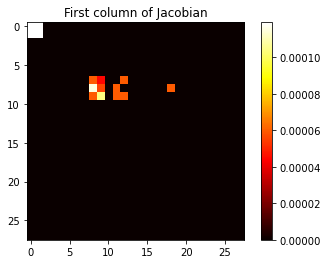

In [13]:
plt.imshow(np.abs(derivative_e_x[:,0].reshape(h,w)), cmap='hot')
plt.title("First column of Jacobian")
plt.colorbar()
plt.show()

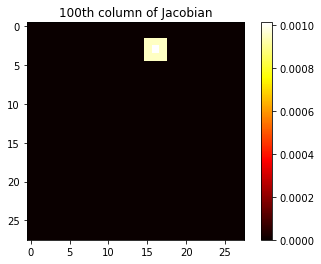

In [14]:
plt.imshow(np.abs(derivative_e_x[:,100].reshape(h,w)), cmap='hot')
plt.title("100th column of Jacobian")
plt.colorbar()
plt.show()

In [15]:
# Approximate covariance of explanation
perturbation_std = 0.1
sigma_squared = perturbation_std ** 2
variance_explanation = sigma_squared * derivative_e_x @ derivative_e_x.T

# Total variance is the trace of the cov. matrix
print("Total Variance of Explanation (Analytical):", np.trace(variance_explanation))

Total Variance of Explanation (Analytical): 249.20330598270203


In [16]:
# Normalized total variance is the trace of the cov. matrix divided by the L2-norm of the unperturbed explanation
print("Normalized Variance of Explanation:", np.trace(variance_explanation) / np.linalg.norm(explanation))

Normalized Variance of Explanation: 8.450162684499418


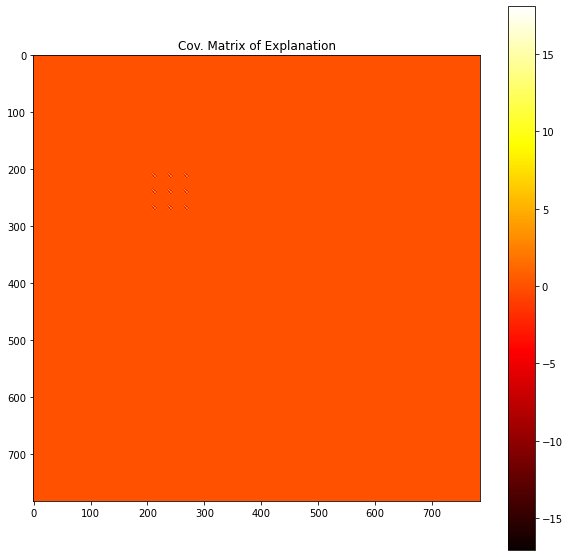

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(variance_explanation, cmap='hot')
plt.title("Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

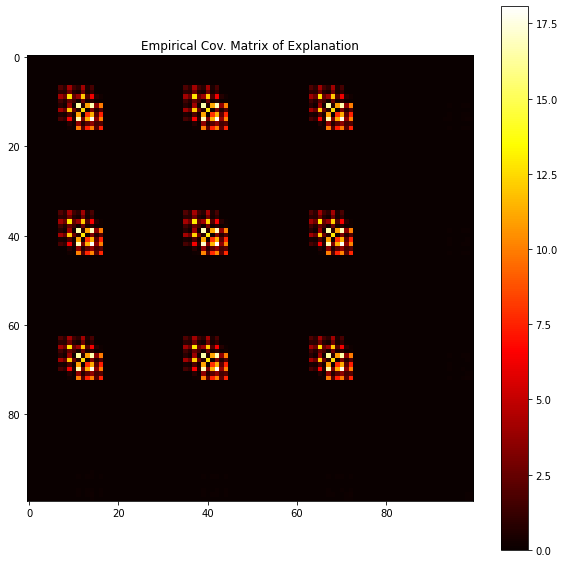

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(variance_explanation)[200:300,200:300], cmap='hot')
plt.title("Empirical Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

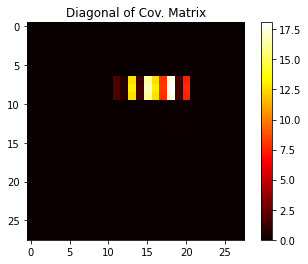

In [18]:
# Per Pixel Variance
plt.imshow(np.abs(np.diag(variance_explanation).reshape(h,w)), cmap='hot')
plt.title("Diagonal of Cov. Matrix")
plt.colorbar()
plt.show()

/home/tchiaburu/anaconda3/envs/tf2_8_gpu/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


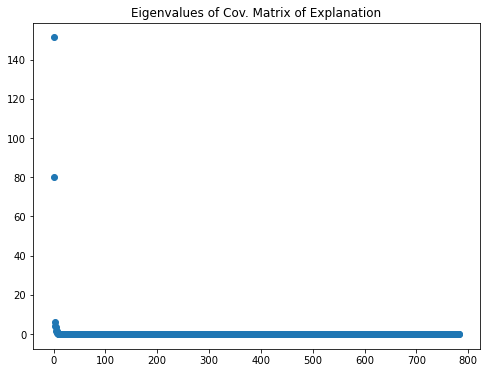

In [19]:
# Explained variance ratio
evals, evecs = np.linalg.eig(variance_explanation)

plt.figure(figsize=(8,6))
plt.plot(evals, 'o')
plt.title('Eigenvalues of Cov. Matrix of Explanation');

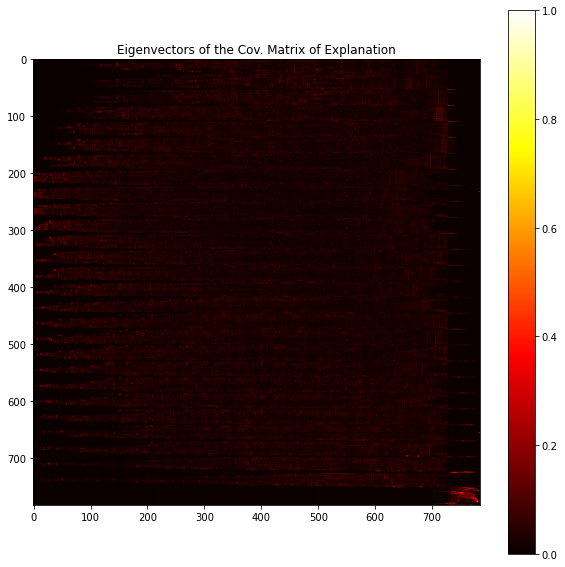

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(evecs), cmap='hot')
plt.title("Eigenvectors of the Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

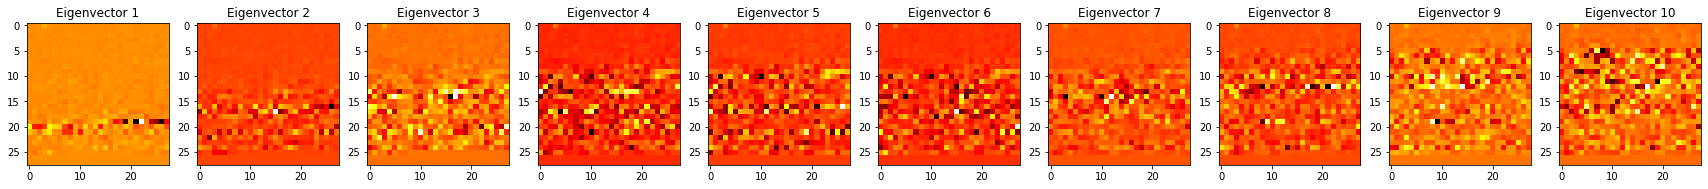

In [21]:
# First k eigenvectors (sorted from highest to lowest eigenvalue)
min_val, max_val = np.min(evecs[:10].real), np.max(evecs[:10].real)
plt.figure(figsize=(30,8))
for i in range(10):
    evec_norm = (evecs[i].real - min_val) / (max_val - min_val)
    plt.subplot(1, 10, i+1)
    plt.imshow(evec_norm.reshape(h,w), cmap='hot')
    plt.title("Eigenvector " + str(i+1))
plt.show()

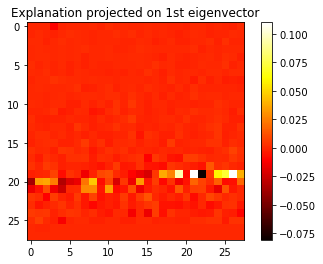

In [22]:
# Project explanation onto the dominant eigenvector
comp_on_projection = np.dot(explanation.numpy().flatten(), evecs[0].real)
projected_explanation = comp_on_projection * evecs[0].real

plt.imshow(projected_explanation.reshape(h,w), cmap='hot')
plt.title("Explanation projected on 1st eigenvector")
plt.colorbar()
plt.show()

### Compute variance empirically

In [23]:
num_perturbations = 10
perturbation_std = 0.1  # same as above for analytical formula
sigma_squared = perturbation_std ** 2

perturbed_explanations = []
for _ in range(num_perturbations):
    # Add Gaussian noise to the input image
    perturbed_image = sample_image + np.random.normal(0, perturbation_std, sample_image.shape)
    perturbed_image = np.clip(perturbed_image, 0, 1)  # Ensure valid pixel range

    # Generate explanation for perturbed input
    perturbed_explanation = explainer.explain(np.expand_dims(perturbed_image, axis=[0,3]), sample_label)
    perturbed_explanations.append(perturbed_explanation.numpy().flatten())

# Stack explanations and compute covariance matrix
explanation_matrix = np.stack(perturbed_explanations, axis=0)
empirical_covariance = np.cov(explanation_matrix, rowvar=False)

# Compute total variance (trace of the covariance matrix)
empirical_total_variance = np.trace(empirical_covariance)

print("Empirical Total Variance of Explanation:", empirical_total_variance)

Empirical Total Variance of Explanation: 45.94835350570945


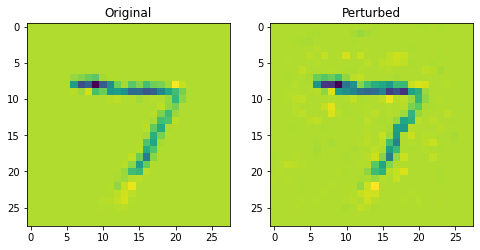

In [24]:
# Display explanation
plt.figure(figsize=(8,10))
plt.subplot(121)
plt.imshow(explanation[0]) # shape (1, 28, 28, 1)
plt.title("Original")
plt.subplot(122)
plt.imshow(perturbed_explanation[0]) # shape (1, 28, 28)
plt.title("Perturbed")
#plt.colorbar()
plt.show()

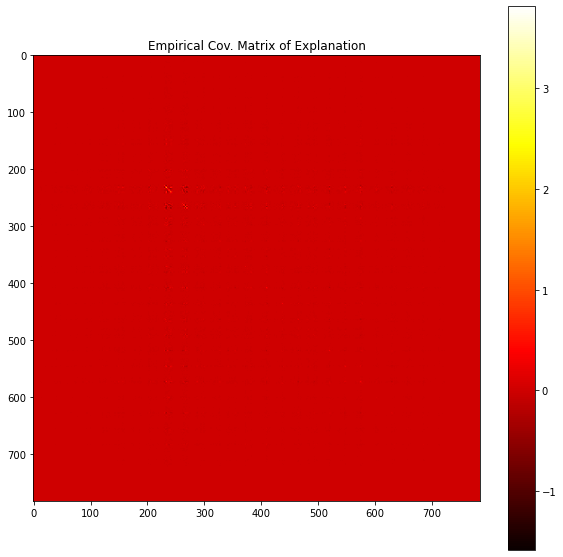

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(empirical_covariance, cmap='hot')
plt.title("Empirical Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

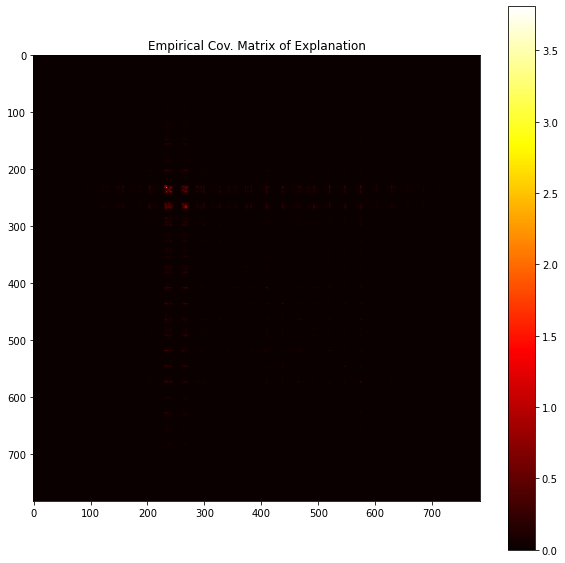

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(empirical_covariance), cmap='hot')
plt.title("Empirical Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

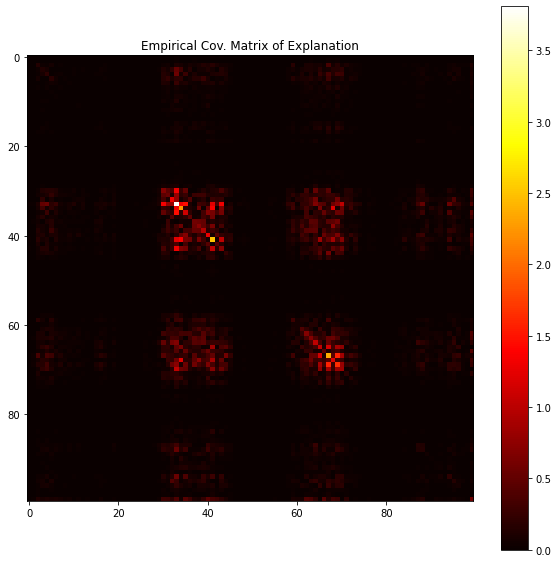

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(empirical_covariance)[200:300,200:300], cmap='hot')
plt.title("Empirical Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

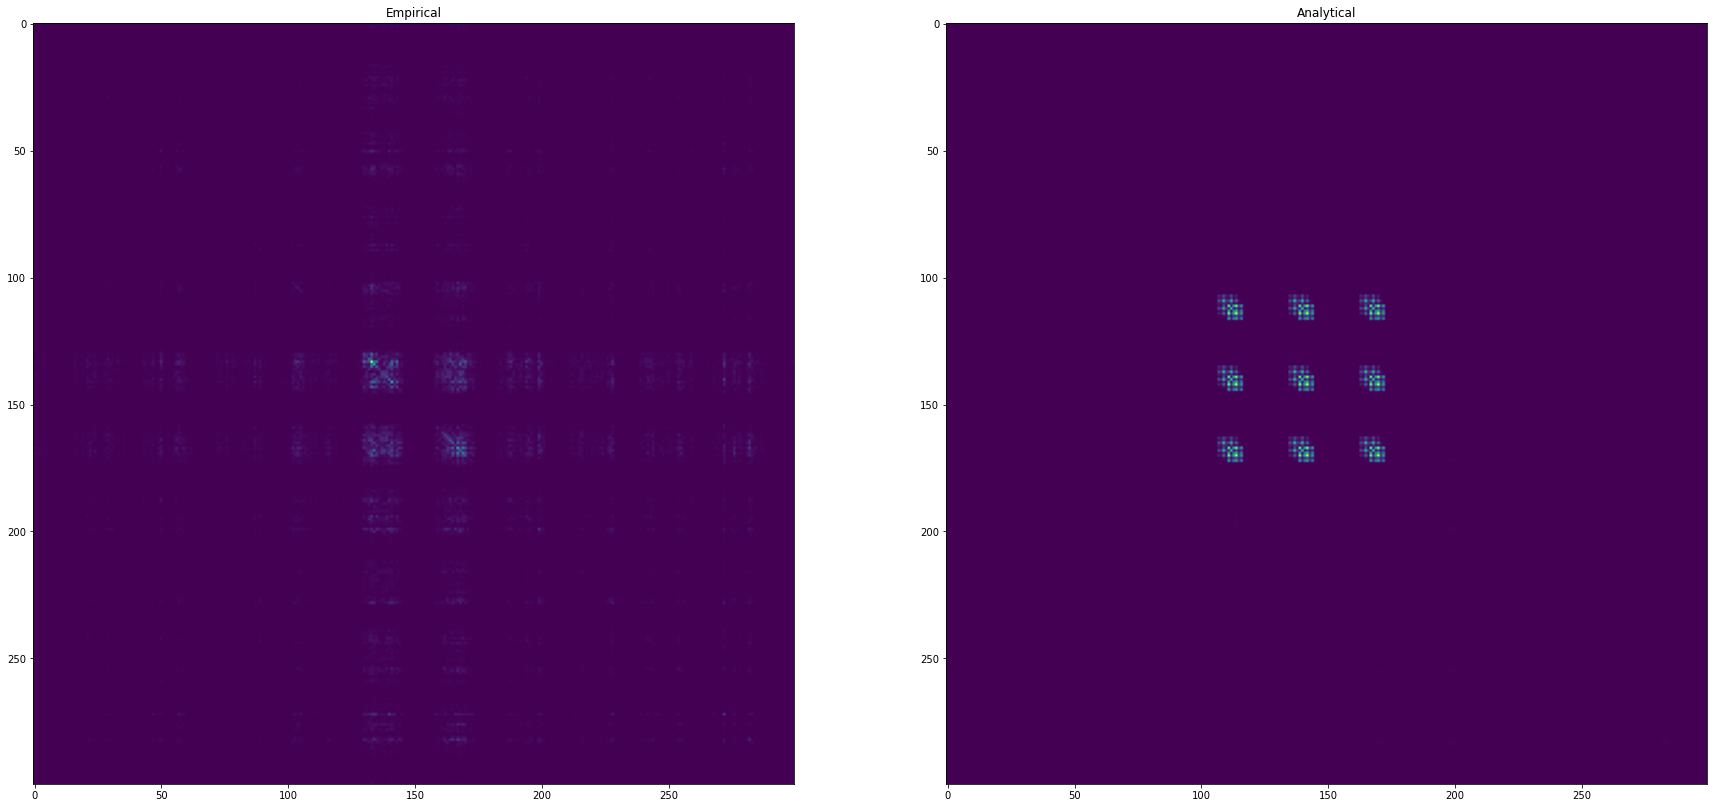

In [36]:
plt.figure(figsize=(30,30))
plt.subplot(121)
plt.imshow(np.abs(empirical_covariance)[100:400,100:400])#, cmap='hot')
plt.title("Empirical")
#plt.colorbar()
plt.subplot(122)
plt.imshow(np.abs(variance_explanation)[100:400,100:400])#, cmap='hot')
plt.title("Analytical")
#plt.colorbar()
plt.show()

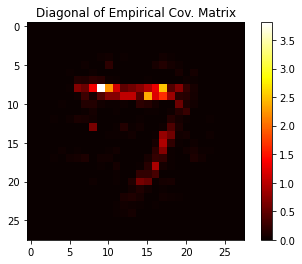

In [26]:
# Per Pixel Variance
plt.imshow(np.abs(np.diag(empirical_covariance).reshape(h,w)), cmap='hot')
plt.title("Diagonal of Empirical Cov. Matrix")
plt.colorbar()
plt.show()

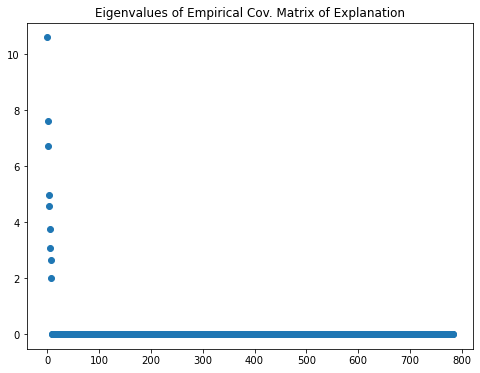

In [27]:
# Explained variance ratio
evals, evecs = np.linalg.eig(empirical_covariance)

plt.figure(figsize=(8,6))
plt.plot(evals, 'o')
plt.title('Eigenvalues of Empirical Cov. Matrix of Explanation');

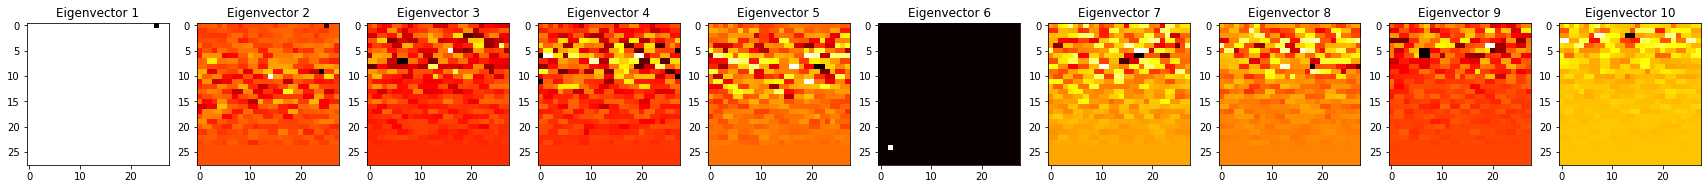

In [28]:
# First k eigenvectors (sorted from highest to lowest eigenvalue)
min_val, max_val = np.min(evecs[:10]), np.max(evecs[:10])
plt.figure(figsize=(30,8))
for i in range(10):
    evec_norm = (evecs[i] - min_val) / (max_val - min_val)
    plt.subplot(1, 10, i+1)
    plt.imshow(evec_norm.real.reshape(h,w), cmap='hot')
    plt.title("Eigenvector " + str(i+1))
plt.show()

### Analytical vs empirical (multiple methods, multiple variances)

In [10]:
explainers = [Saliency(model),
              GradientInput(model),
              IntegratedGradients(model, steps=20, batch_size=1),
              GuidedBackprop(model),
              Occlusion(model, batch_size=1) # with default patch_size and patch_stride
              #SmoothGrad(model, nb_samples=20, batch_size=1), # takes long
              #SquareGrad(model, nb_samples=20, batch_size=1),
              #DeconvNet(model),
              #VarGrad(model, nb_samples=20, batch_size=1),
              #Lime(model, nb_samples = 20, batch_size=1),
              #KernelShap(model, nb_samples = 20, batch_size=1)
             ]

In [11]:
#stds = [0.1, 0.2, 0.3]#, 0.4, 0.5] # std. deviations
#stds = [1e-15, 1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 1e-3, 1e-1]
stds = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
num_perturbations = 500#1000 # for empirical cov.
dx = 1e-3 # differential for ana. cov.
h = w = x_train[0].shape[0] # (28, 28, 3)
n = np.product(np.shape(x_train[0])[:-1]) # for simplicity, treat RGB channels as one point/step
m = n

In [12]:
sample_indexes = [0]#, 20, 100]
#sample_indexes = np.arange(10)
results, cov_mats, jacobi_mats, empirical_exps, unperturbed_exps = {}, {}, {}, {}, {}

for sample_index in sample_indexes:
    # Read sample image and label
    sample_image, sample_label = x_test[sample_index], y_test[sample_index]
    sample_label = np.expand_dims(sample_label, axis=[0,1])

    # Store results for plotting
    results[sample_index]  = {explainer.__class__.__name__: {'analytical': [], 'empirical': []} for explainer in explainers}
    cov_mats[sample_index] = {explainer.__class__.__name__: {'analytical': [], 'empirical': []} for explainer in explainers}
    jacobi_mats[sample_index] = {}
    empirical_exps[sample_index] = {}
    unperturbed_exps[sample_index] = {}

    print('\n*********')
    print('Sample ' + str(sample_index))
    for explainer in explainers:
        name = explainer.__class__.__name__
        empirical_exps[sample_index][name] = {}
        print('\n' + name)
        
        # Get explanation in (unperturbed) x
        explanation = explainer(np.expand_dims(sample_image, axis=0), sample_label)[0]
        unperturbed_exps[sample_index][name] = explanation.numpy().flatten()
        
        # Norm of explanation (for normalization of total variance)
        norm_exp_squared = np.linalg.norm(explanation)**2
        """
        # Precompute Jacobian (stays fixed for every std)
        derivative_e_x = np.zeros((m, n))
        # For every pixel perturbation, we get a new column in the Jacobian
        for i in range(h):
            for j in range(w):
                # Perturb pixel (i, j)
                perturbed_image = np.copy(sample_image)
                perturbed_image[i, j, :] += dx
                perturbed_image = np.clip(perturbed_image, 0, 1)  # Keep within valid range
    
                # Compute explanation for perturbed image
                perturbed_explanation = explainer(np.expand_dims(perturbed_image, axis=0), sample_label)[0]
    
                # Fill out the corresponding column in the jacobian
                derivative_2d = (perturbed_explanation - explanation) / dx
                flat_ind = i * w + j
                derivative_e_x[:, flat_ind] = derivative_2d.numpy().reshape(m, )
        jacobi_mats[sample_index][name] = derivative_e_x
        """
        for std in stds:
            """
            ### Analytical
            sigma_squared = std ** 2
            covariance_ana = sigma_squared * derivative_e_x @ derivative_e_x.T
            
            # Total variance is the trace of the cov. matrix
            total_var = np.trace(covariance_ana)/norm_exp_squared
            print("Analytical Variance (std = ", std, "):", total_var)
            results[sample_index][name]['analytical'].append(total_var)
            cov_mats[sample_index][name]['analytical'].append(covariance_ana)
            """
            ### Empirical
            perturbed_explanations = []
            for _ in range(num_perturbations):
                # Add Gaussian noise to the input image
                perturbed_image = sample_image + np.random.normal(0, std, sample_image.shape)
                perturbed_image = np.clip(perturbed_image, 0, 1)  # Ensure valid pixel range
    
                # Generate explanation for perturbed input
                perturbed_explanation = explainer.explain(np.expand_dims(perturbed_image, axis=0), sample_label)[0]
                perturbed_explanations.append(perturbed_explanation.numpy().flatten())
            
            # Stack explanations and compute covariance matrix
            explanation_matrix = np.stack(perturbed_explanations, axis=0).squeeze()
            covariance_emp = np.cov(explanation_matrix, rowvar=False)
            
            total_var = np.trace(covariance_emp)/norm_exp_squared
            print("Empirical Variance (std = ", std, "):", total_var)
            results[sample_index][name]['empirical'].append(total_var)
            cov_mats[sample_index][name]['empirical'].append(covariance_emp)
            
            # Store explanations for normality checks
            empirical_exps[sample_index][name][std] = np.stack(perturbed_explanations, axis=0)


*********
Sample 0

Saliency
Empirical Variance (std =  1e-06 ): 0.09721814174751421
Empirical Variance (std =  1e-05 ): 0.09675019240173144
Empirical Variance (std =  0.0001 ): 0.09907065710233436
Empirical Variance (std =  0.001 ): 0.10074349685258847
Empirical Variance (std =  0.01 ): 0.10594559418983956
Empirical Variance (std =  0.1 ): 0.18720819852489864

GradientInput
Empirical Variance (std =  1e-06 ): 0.0047018848987948345
Empirical Variance (std =  1e-05 ): 0.004808421246583133
Empirical Variance (std =  0.0001 ): 0.004729647369928641
Empirical Variance (std =  0.001 ): 0.005037870357399242
Empirical Variance (std =  0.01 ): 0.013127978848024111
Empirical Variance (std =  0.1 ): 0.14635749547416102

IntegratedGradients
Empirical Variance (std =  1e-06 ): 0.0033112079149704237
Empirical Variance (std =  1e-05 ): 0.0034694209082463865
Empirical Variance (std =  0.0001 ): 0.003534782245713575
Empirical Variance (std =  0.001 ): 0.0034813852513251205
Empirical Variance (std =  0

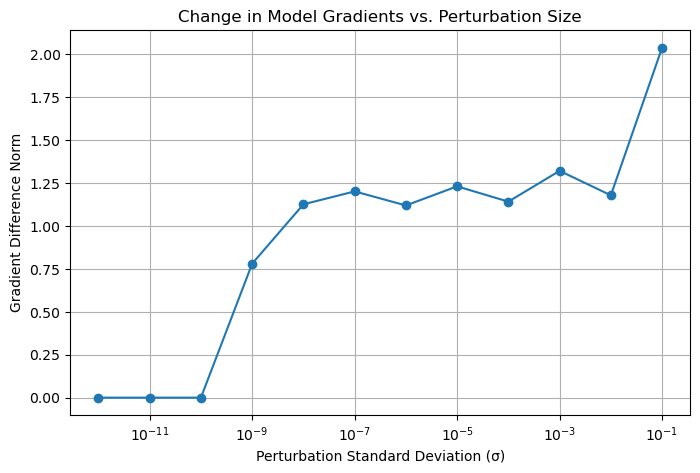

In [21]:
### Test how gradients in the model vary for different sigmas
# Function to compute gradients w.r.t. input image
def get_input_gradients(model, image, label):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image, training=False)
        loss = prediction[0, label]  # Extract logit for the correct class
    gradients = tape.gradient(loss, image)  # Compute dL/dx
    return gradients.numpy()

# Select test sample
sample_index = 0
sample_image = x_test[sample_index:sample_index+1]  # Keep batch dimension
sample_label = y_test[sample_index]

# Compute original gradients
original_gradients = get_input_gradients(model, sample_image, sample_label)

# Define small perturbation values (log scale for better visualization)
sigma_values = np.logspace(-12, -1, 12)
gradient_differences = []

# Compute gradient differences for different small perturbations
for sigma in sigma_values:
    perturbed_image = sample_image + np.random.normal(0, sigma, sample_image.shape)
    perturbed_image = np.clip(perturbed_image, 0, 1)  # Keep valid range

    perturbed_gradients = get_input_gradients(model, perturbed_image, sample_label)
    
    # Compute Frobenius norm of gradient difference
    grad_diff_norm = np.linalg.norm(original_gradients - perturbed_gradients)
    gradient_differences.append(grad_diff_norm)

# Plot gradient norm differences vs. perturbation scale
plt.figure(figsize=(8, 5))
plt.plot(sigma_values, gradient_differences, marker='o', linestyle='-')
plt.xscale("log")  # Use log scale for better visualization
#plt.yscale("log")
plt.xlabel("Perturbation Standard Deviation (σ)")
plt.ylabel("Gradient Difference Norm")
plt.title("Change in Model Gradients vs. Perturbation Size")
plt.grid(True)
plt.show()

### Normality Checks

In [10]:
import pickle
experiments = {'results': results, 
               'cov_mats': cov_mats, 
               'jacobi_mats': jacobi_mats, 
               'empirical_exps': empirical_exps, 
               'unperturbed_exps': unperturbed_exps}

with open('./experiments/experiments_input_mnist_10ex_500pert.pickle', 'wb') as handle:
    pickle.dump(experiments, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('./experiments/experiments_input_mnist.pickle', 'rb') as handle:
#    experiments = pickle.load(handle)

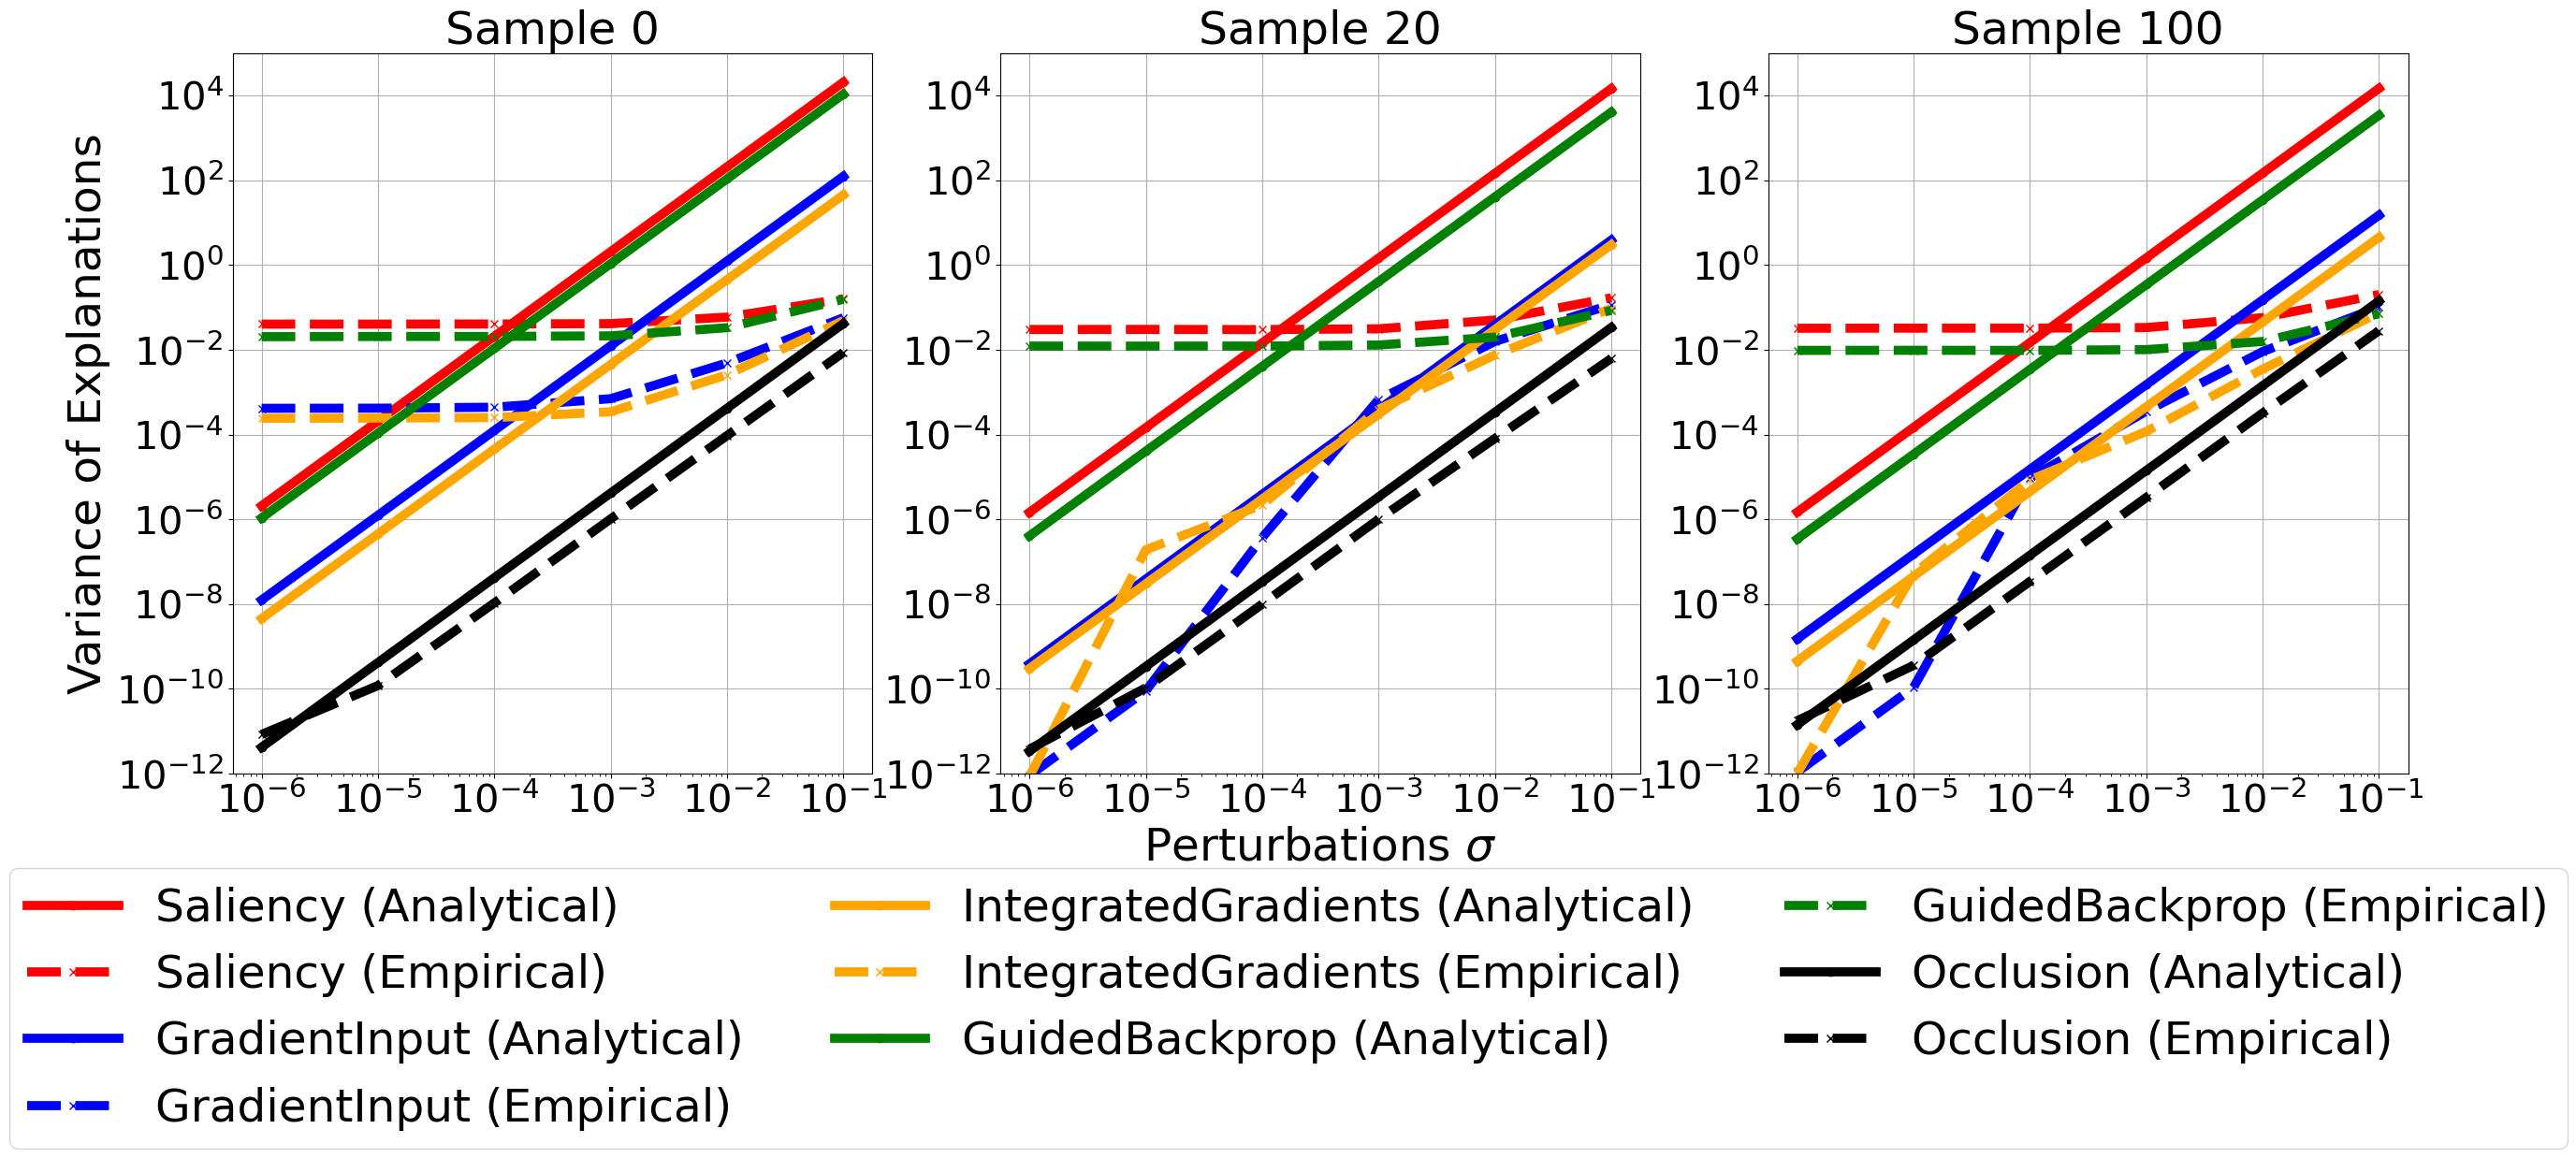

In [41]:
# Plot seveeral samples
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
fsize=35
fig = plt.figure(figsize=(30, 10))
for i, sample_id in enumerate(sample_indexes): 
    plt.subplot(1, 3, i+1)
    for (name, data), col in zip(experiments['results'][sample_id].items(), colors):
        plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col, lw=7)
        plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed', lw=7)
    plt.title('Sample ' + str(sample_id), fontsize=fsize)
    if i==1: plt.xlabel('Perturbations $\sigma$', fontsize=fsize)
    if i==0: plt.ylabel('Variance of Explanations', fontsize=fsize)
    plt.xscale('log');plt.yscale('log')
    plt.xticks(fontsize=fsize-5);plt.yticks(fontsize=fsize-5)
    plt.ylim([1e-12, 1e+5])
    if i==2: plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(-0.75, -0.1), ncol=3)
    plt.grid(True)
#plt.suptitle('Analytical vs Empirical Uncertainties, MNIST', fontsize=fsize+5)
plt.show()
fig.savefig('./figures/uncertainties_input_mnist.png', bbox_inches='tight')

In [25]:
# Aggregate results
agg_results = {explainer.__class__.__name__: {'analytical': [], 'empirical': []} for explainer in explainers}
for explainer in explainers:
    name = explainer.__class__.__name__
    for approach in ['analytical', 'empirical']:
        agg_sum = np.zeros(len(stds))
        for ex_ind in sample_indexes:
            sample_res = experiments['results'][ex_ind][name][approach]
            if np.isnan(sample_res).any():
                sample_res = np.finfo(float).eps * np.ones(len(stds))
            agg_sum += sample_res
        agg_results[name][approach] = agg_sum/len(sample_indexes)
agg_results

{'Saliency': {'analytical': array([1.82172805e-06, 1.82172805e-04, 1.82172805e-02, 1.82172805e+00,
         1.82172805e+02, 1.82172805e+04]),
  'empirical': array([0.0337956 , 0.03364739, 0.03372186, 0.0352996 , 0.04824366,
         0.1622238 ])},
 'GradientInput': {'analytical': array([6.78561408e-09, 6.78561405e-07, 6.78561405e-05, 6.78561405e-03,
         6.78561405e-01, 6.78561405e+01]),
  'empirical': array([0.00020213, 0.0001991 , 0.00021336, 0.00065757, 0.00574613,
         0.07437774])},
 'IntegratedGradients': {'analytical': array([5.77971168e-09, 5.77971166e-07, 5.77971166e-05, 5.77971166e-03,
         5.77971166e-01, 5.77971166e+01]),
  'empirical': array([0.00017212, 0.00018206, 0.0001916 , 0.00041553, 0.00351094,
         0.06051774])},
 'GuidedBackprop': {'analytical': array([5.60707652e-07, 5.60707652e-05, 5.60707652e-03, 5.60707652e-01,
         5.60707652e+01, 5.60707652e+03]),
  'empirical': array([0.01230946, 0.01229596, 0.01233813, 0.01287889, 0.02040943,
         0

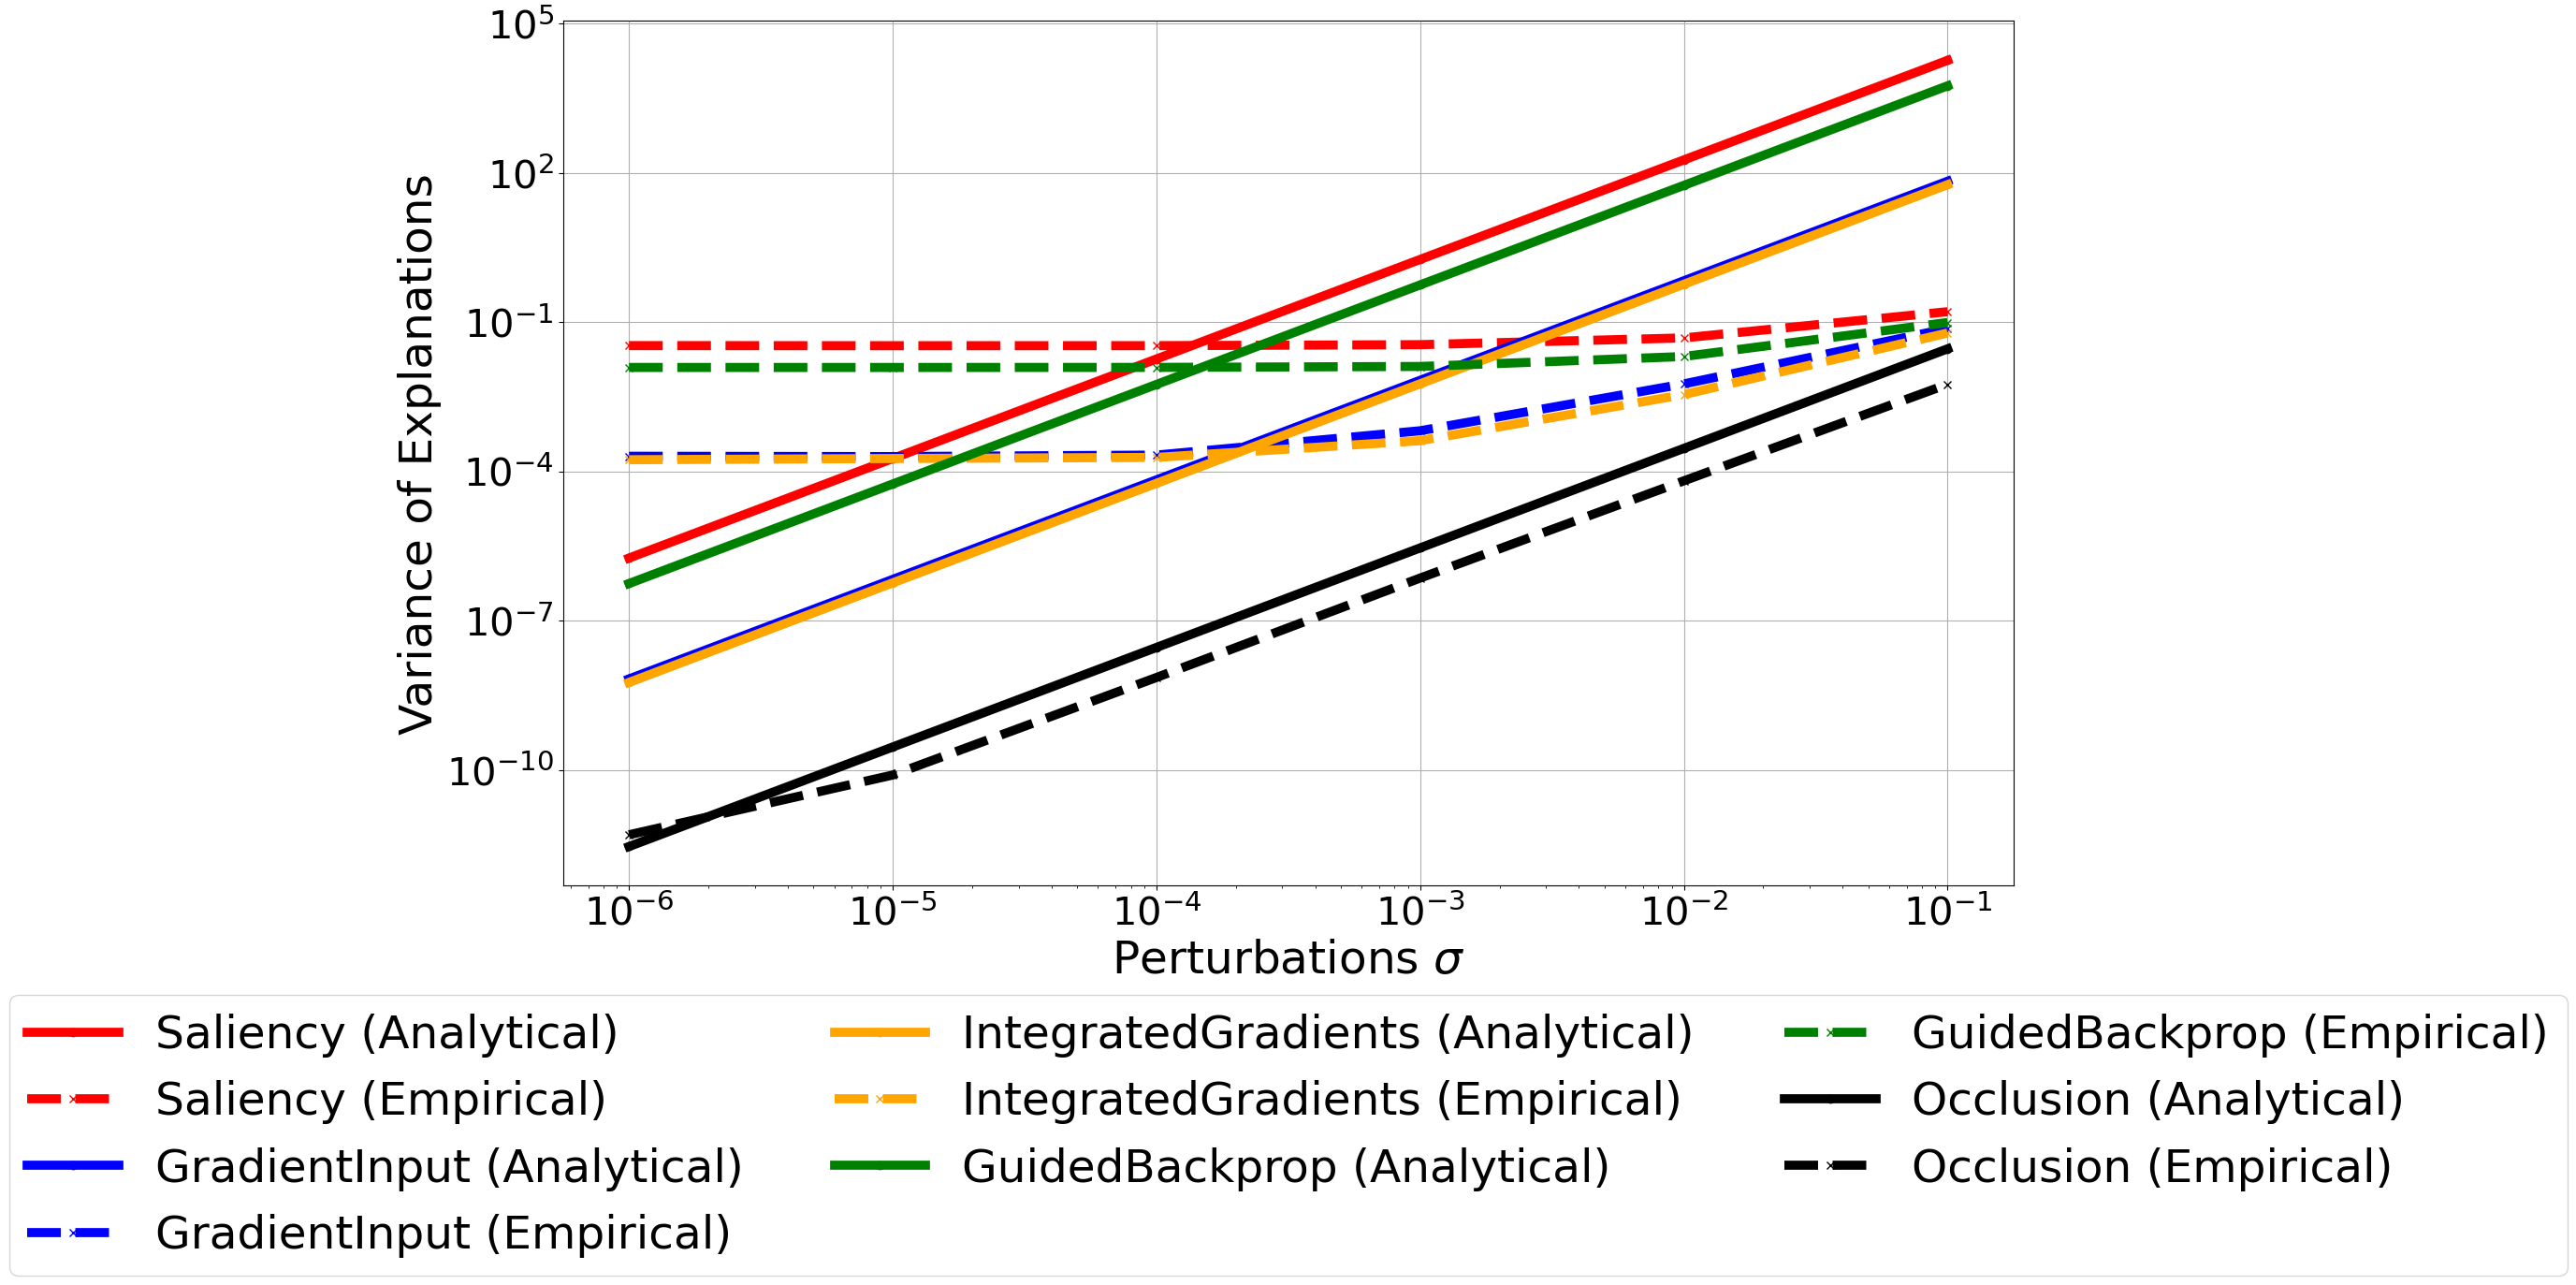

In [27]:
# Plot aggregations
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
fsize=35
fig = plt.figure(figsize=(20, 12))
for (name, data), col in zip(agg_results.items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col, lw=7)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed', lw=7)
plt.xlabel('Perturbations $\sigma$', fontsize=fsize)
plt.ylabel('Variance of Explanations', fontsize=fsize)
plt.xscale('log');plt.yscale('log')
plt.xticks(fontsize=fsize-5);plt.yticks(fontsize=fsize-5)
#plt.ylim([1e-12, 5e-1])
plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(0.5, -0.1), 
           ncol=3)
plt.grid(True)
#plt.suptitle('Analytical vs Empirical Uncertainties, Auto MPG', fontsize=fsize+5)
plt.show()
fig.savefig('./figures/uncertainties_input_mnist_agg.png', bbox_inches='tight')

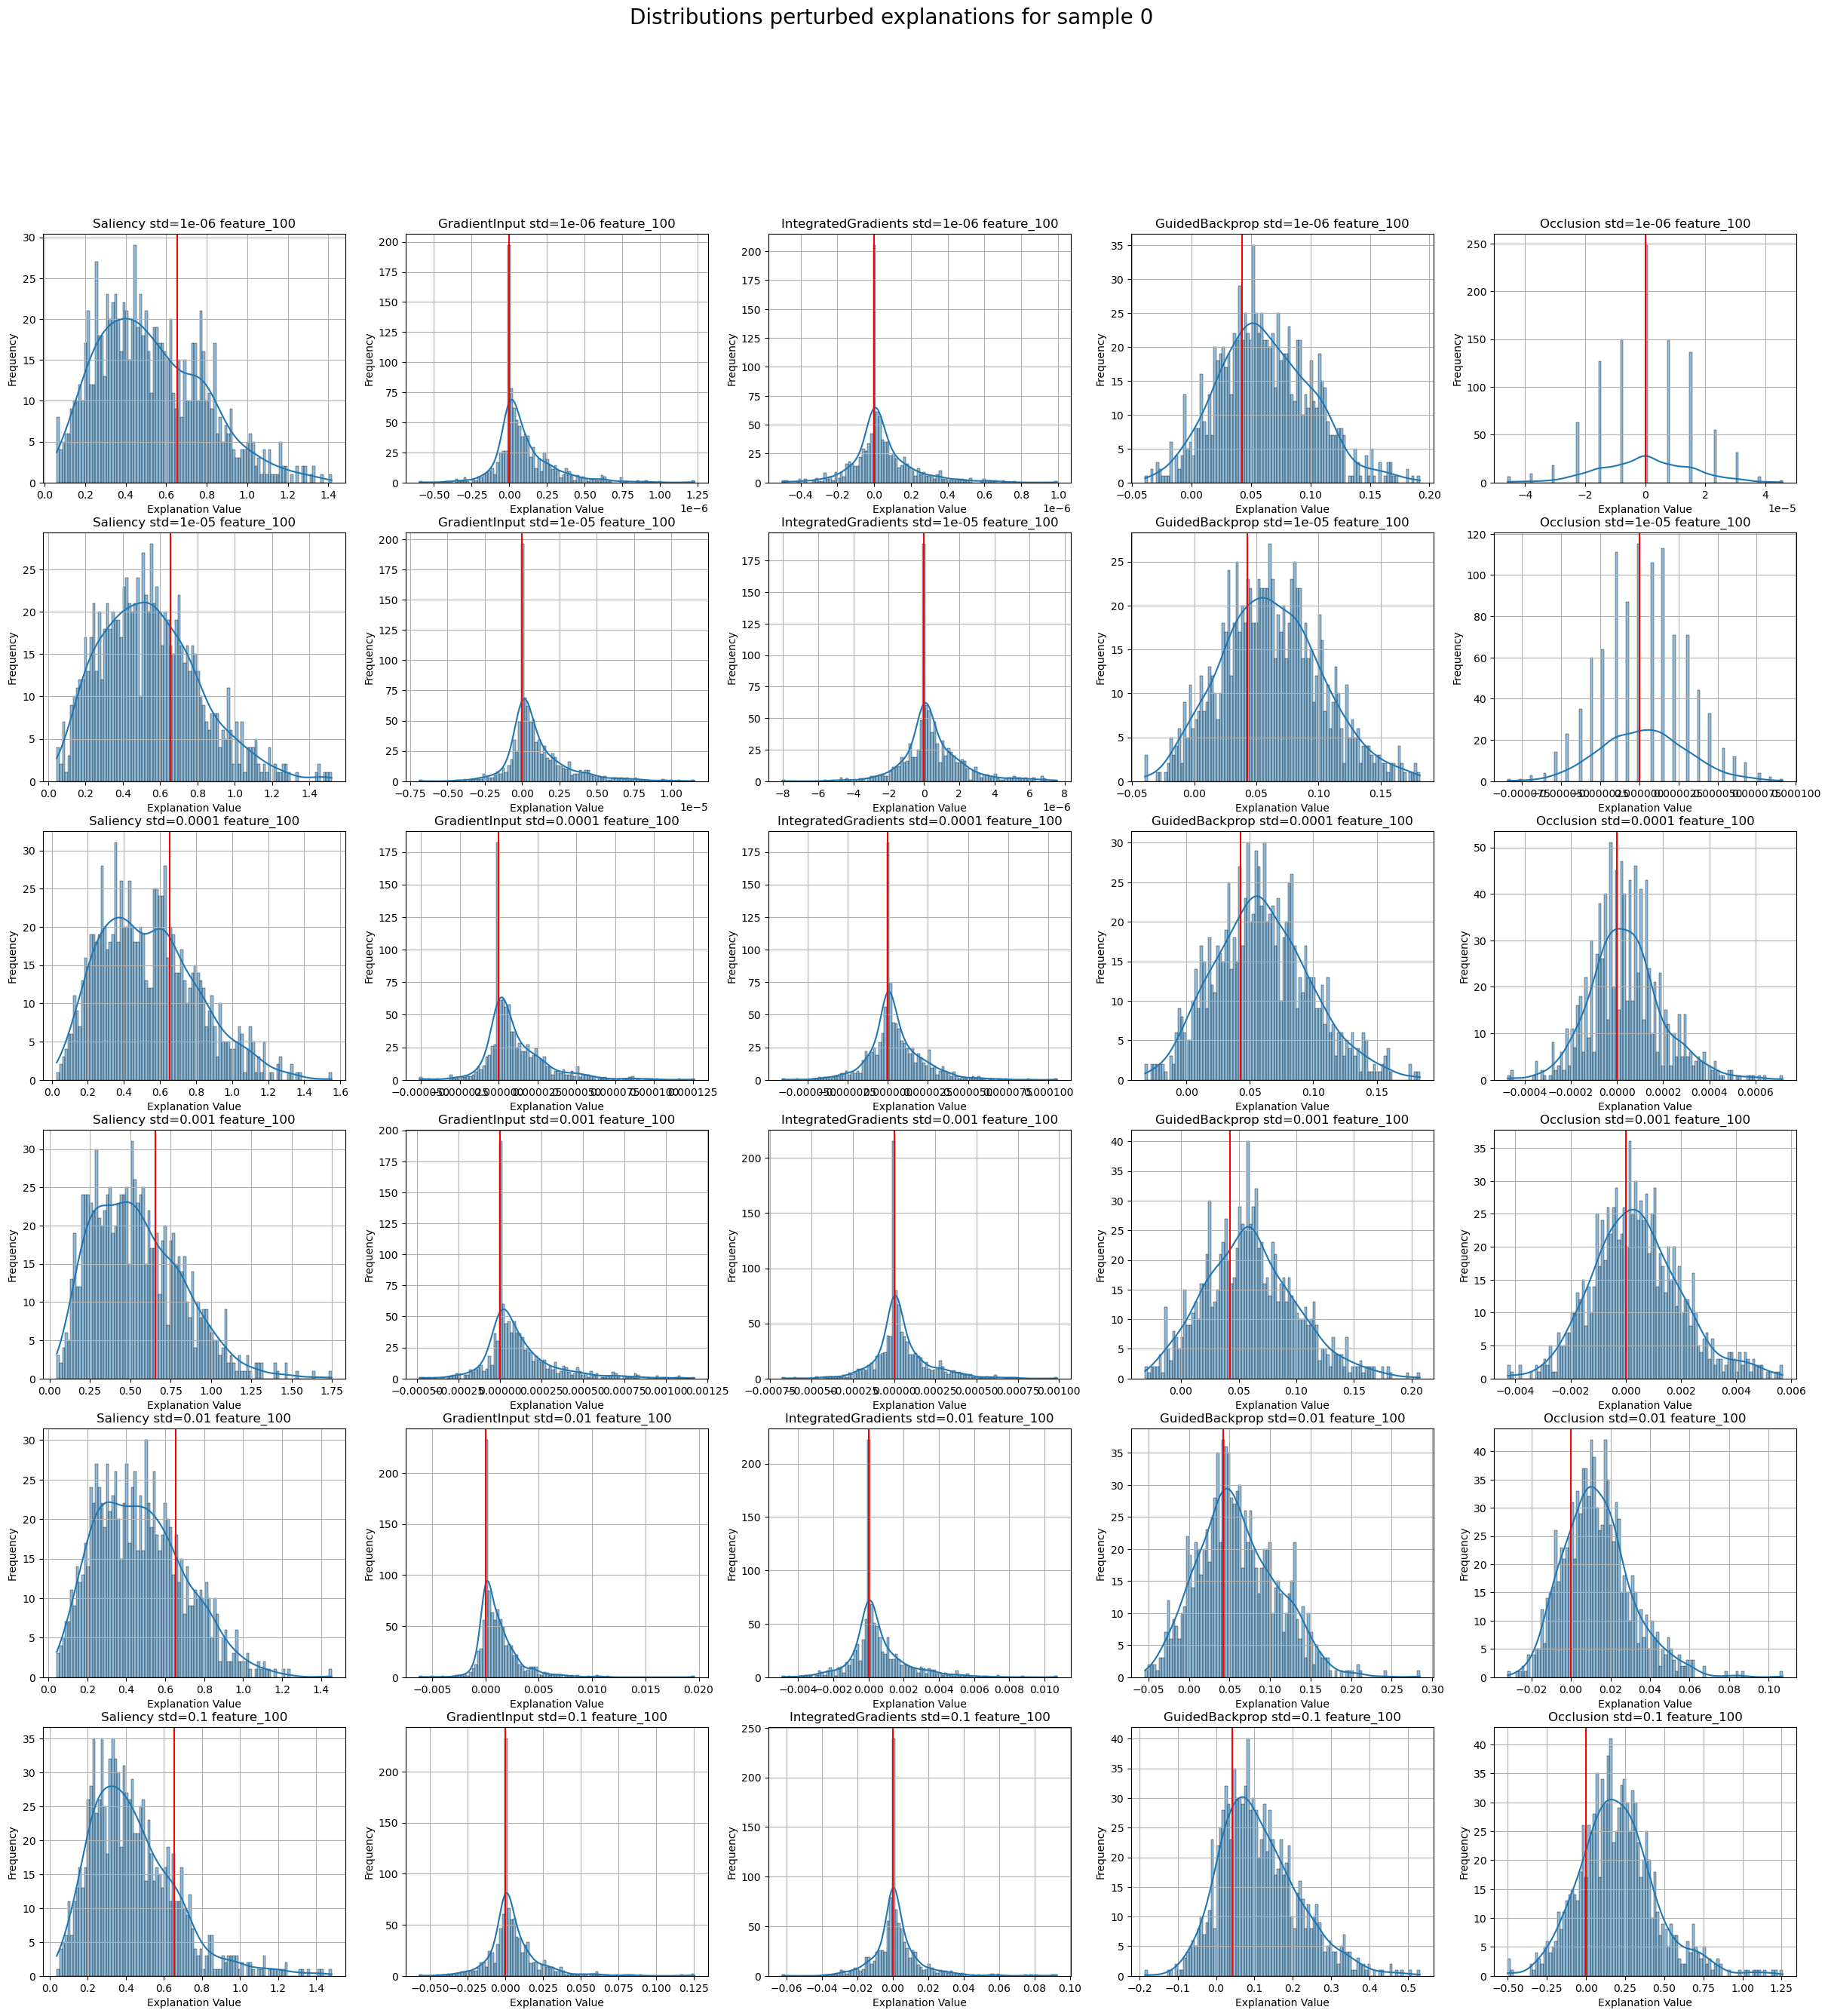

In [59]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 0, 100
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(empirical_exps[sample_id]): 
    for j, std in enumerate(stds):
        plt.subplot(6,5,5*j+i+1)
        sns.histplot(empirical_exps[sample_id][exp_name][std][:,feature_id], kde=True, bins=100)
        plt.axvline(x=unperturbed_exps[sample_id][exp_name][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ' std=' + str(std) + ' feature_' + str(feature_id))
        plt.xlabel("Explanation Value")
        plt.ylabel("Frequency")
        plt.grid()
plt.show()

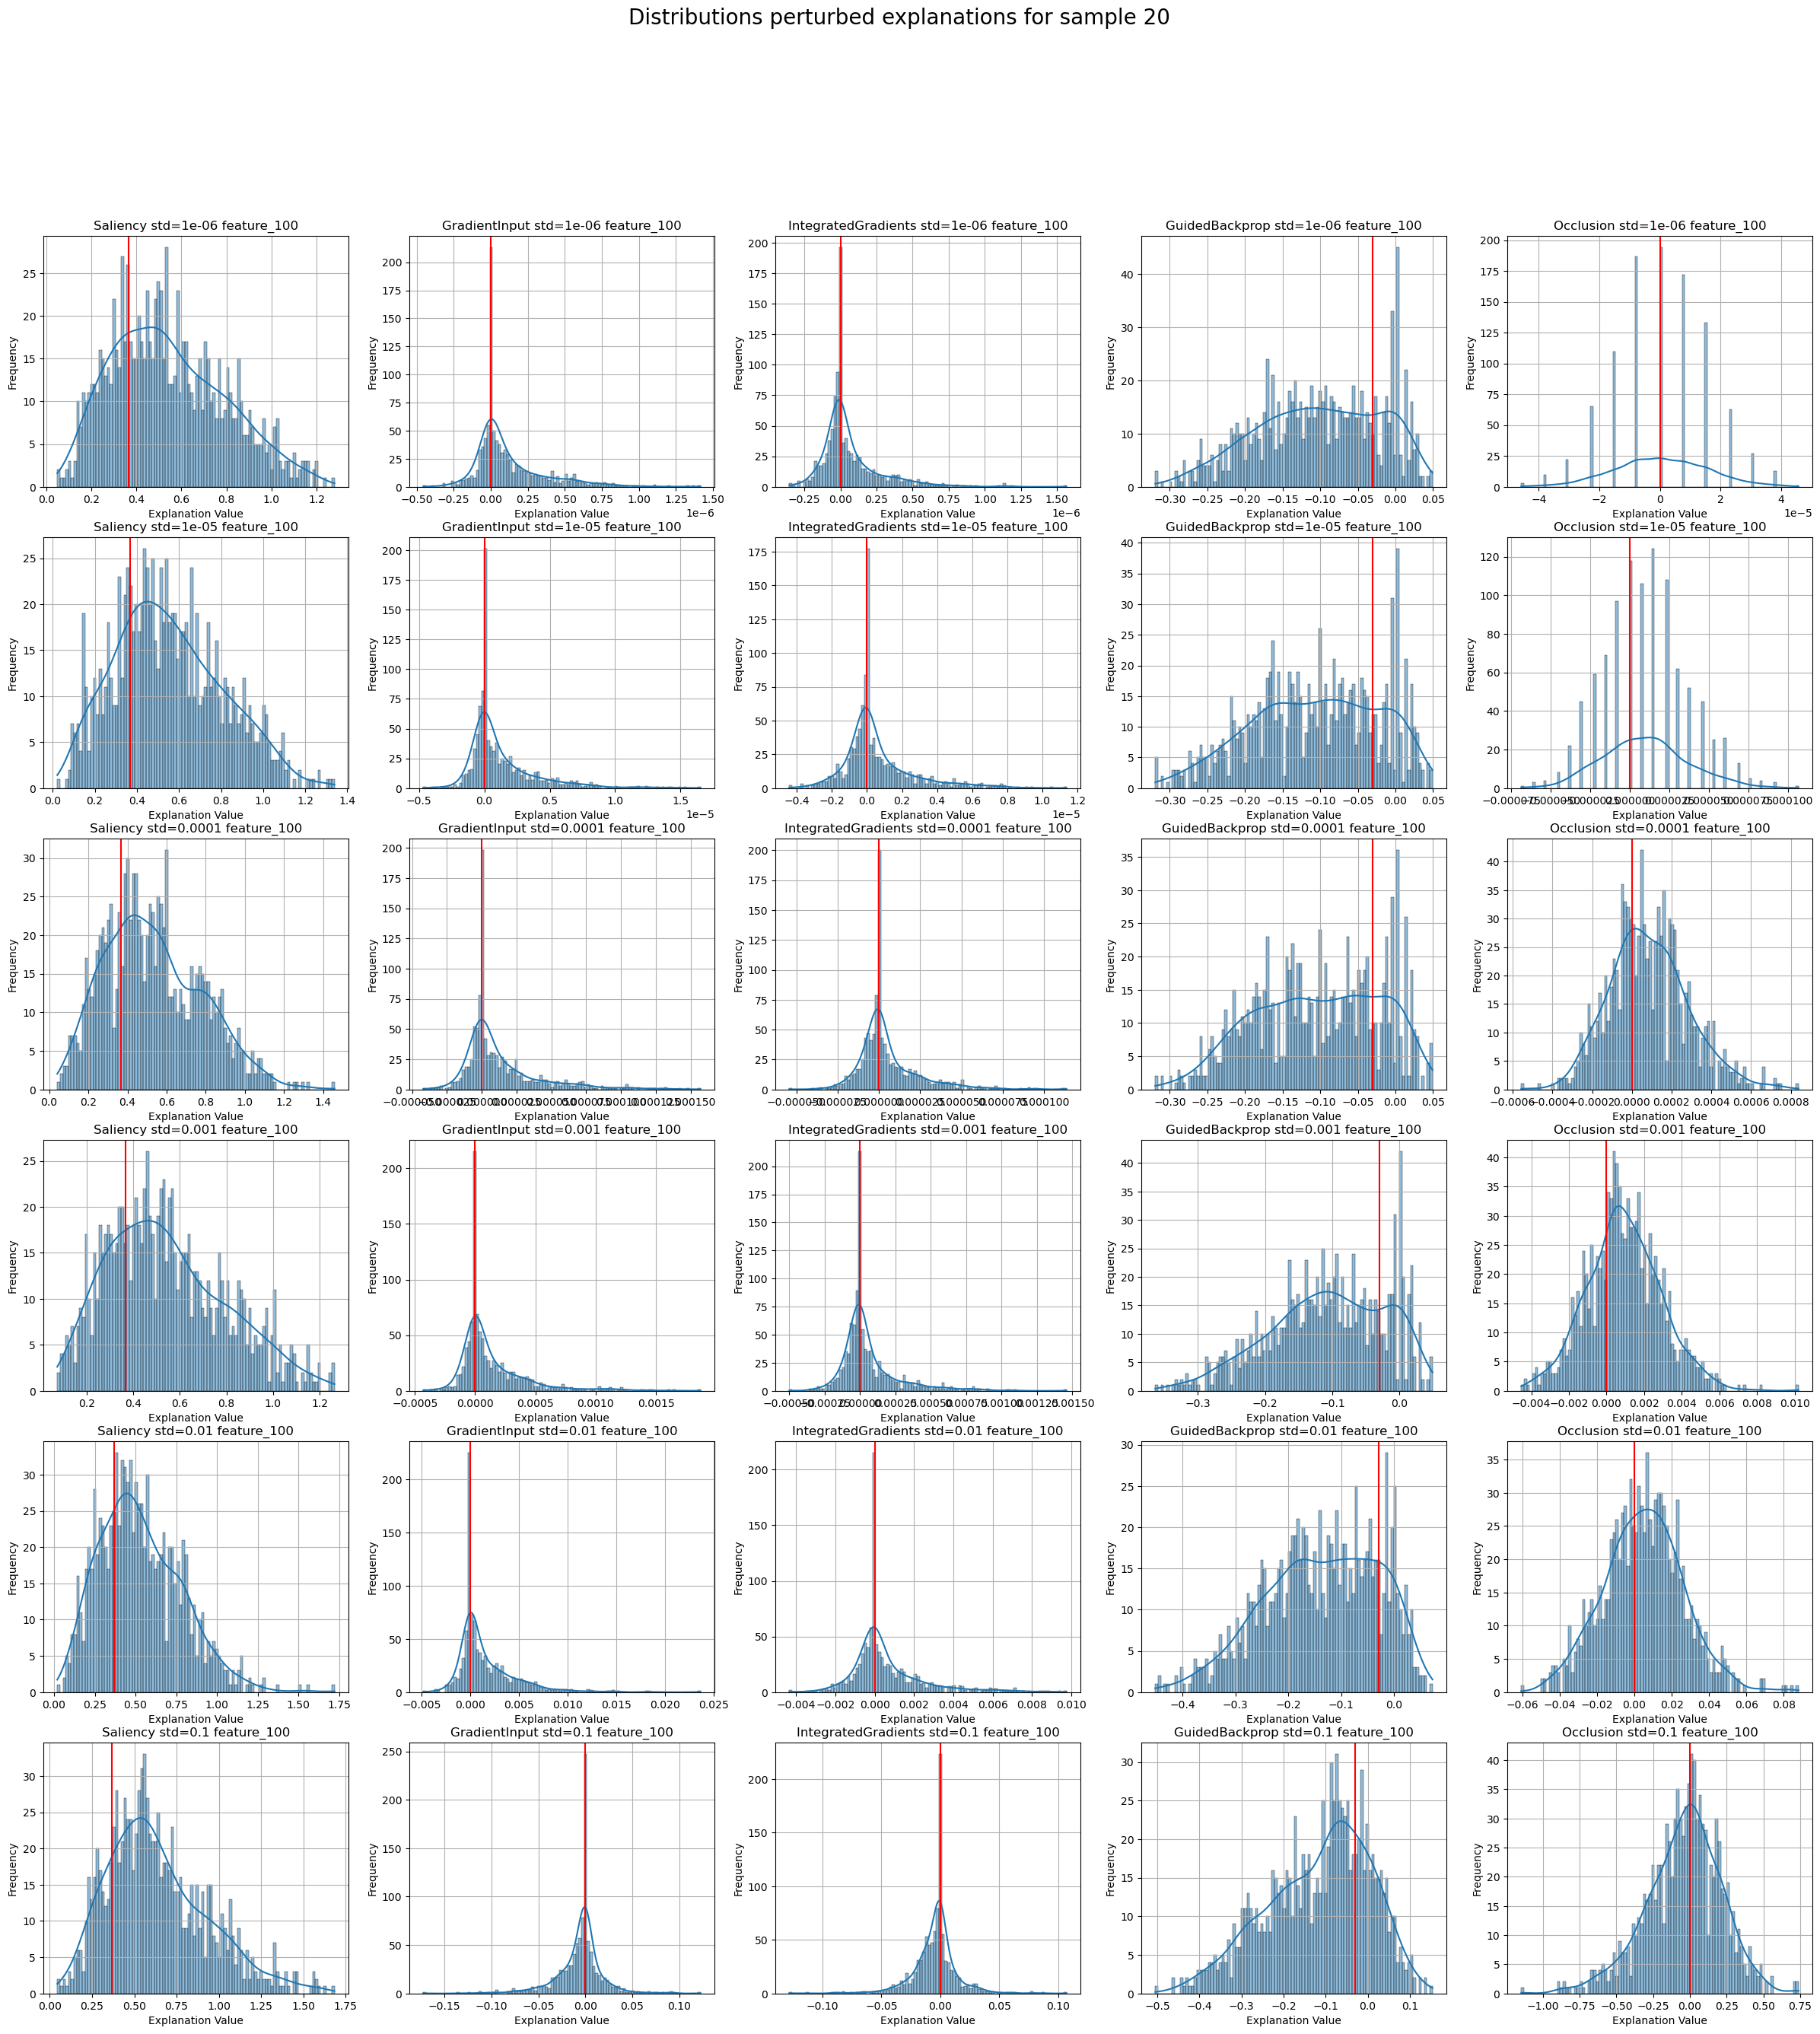

In [60]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 20, 100
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(empirical_exps[sample_id]): 
    for j, std in enumerate(stds):
        plt.subplot(6,5,5*j+i+1)
        sns.histplot(empirical_exps[sample_id][exp_name][std][:,feature_id], kde=True, bins=100)
        plt.axvline(x=unperturbed_exps[sample_id][exp_name][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ' std=' + str(std) + ' feature_' + str(feature_id))
        plt.xlabel("Explanation Value")
        plt.ylabel("Frequency")
        plt.grid()
plt.show()

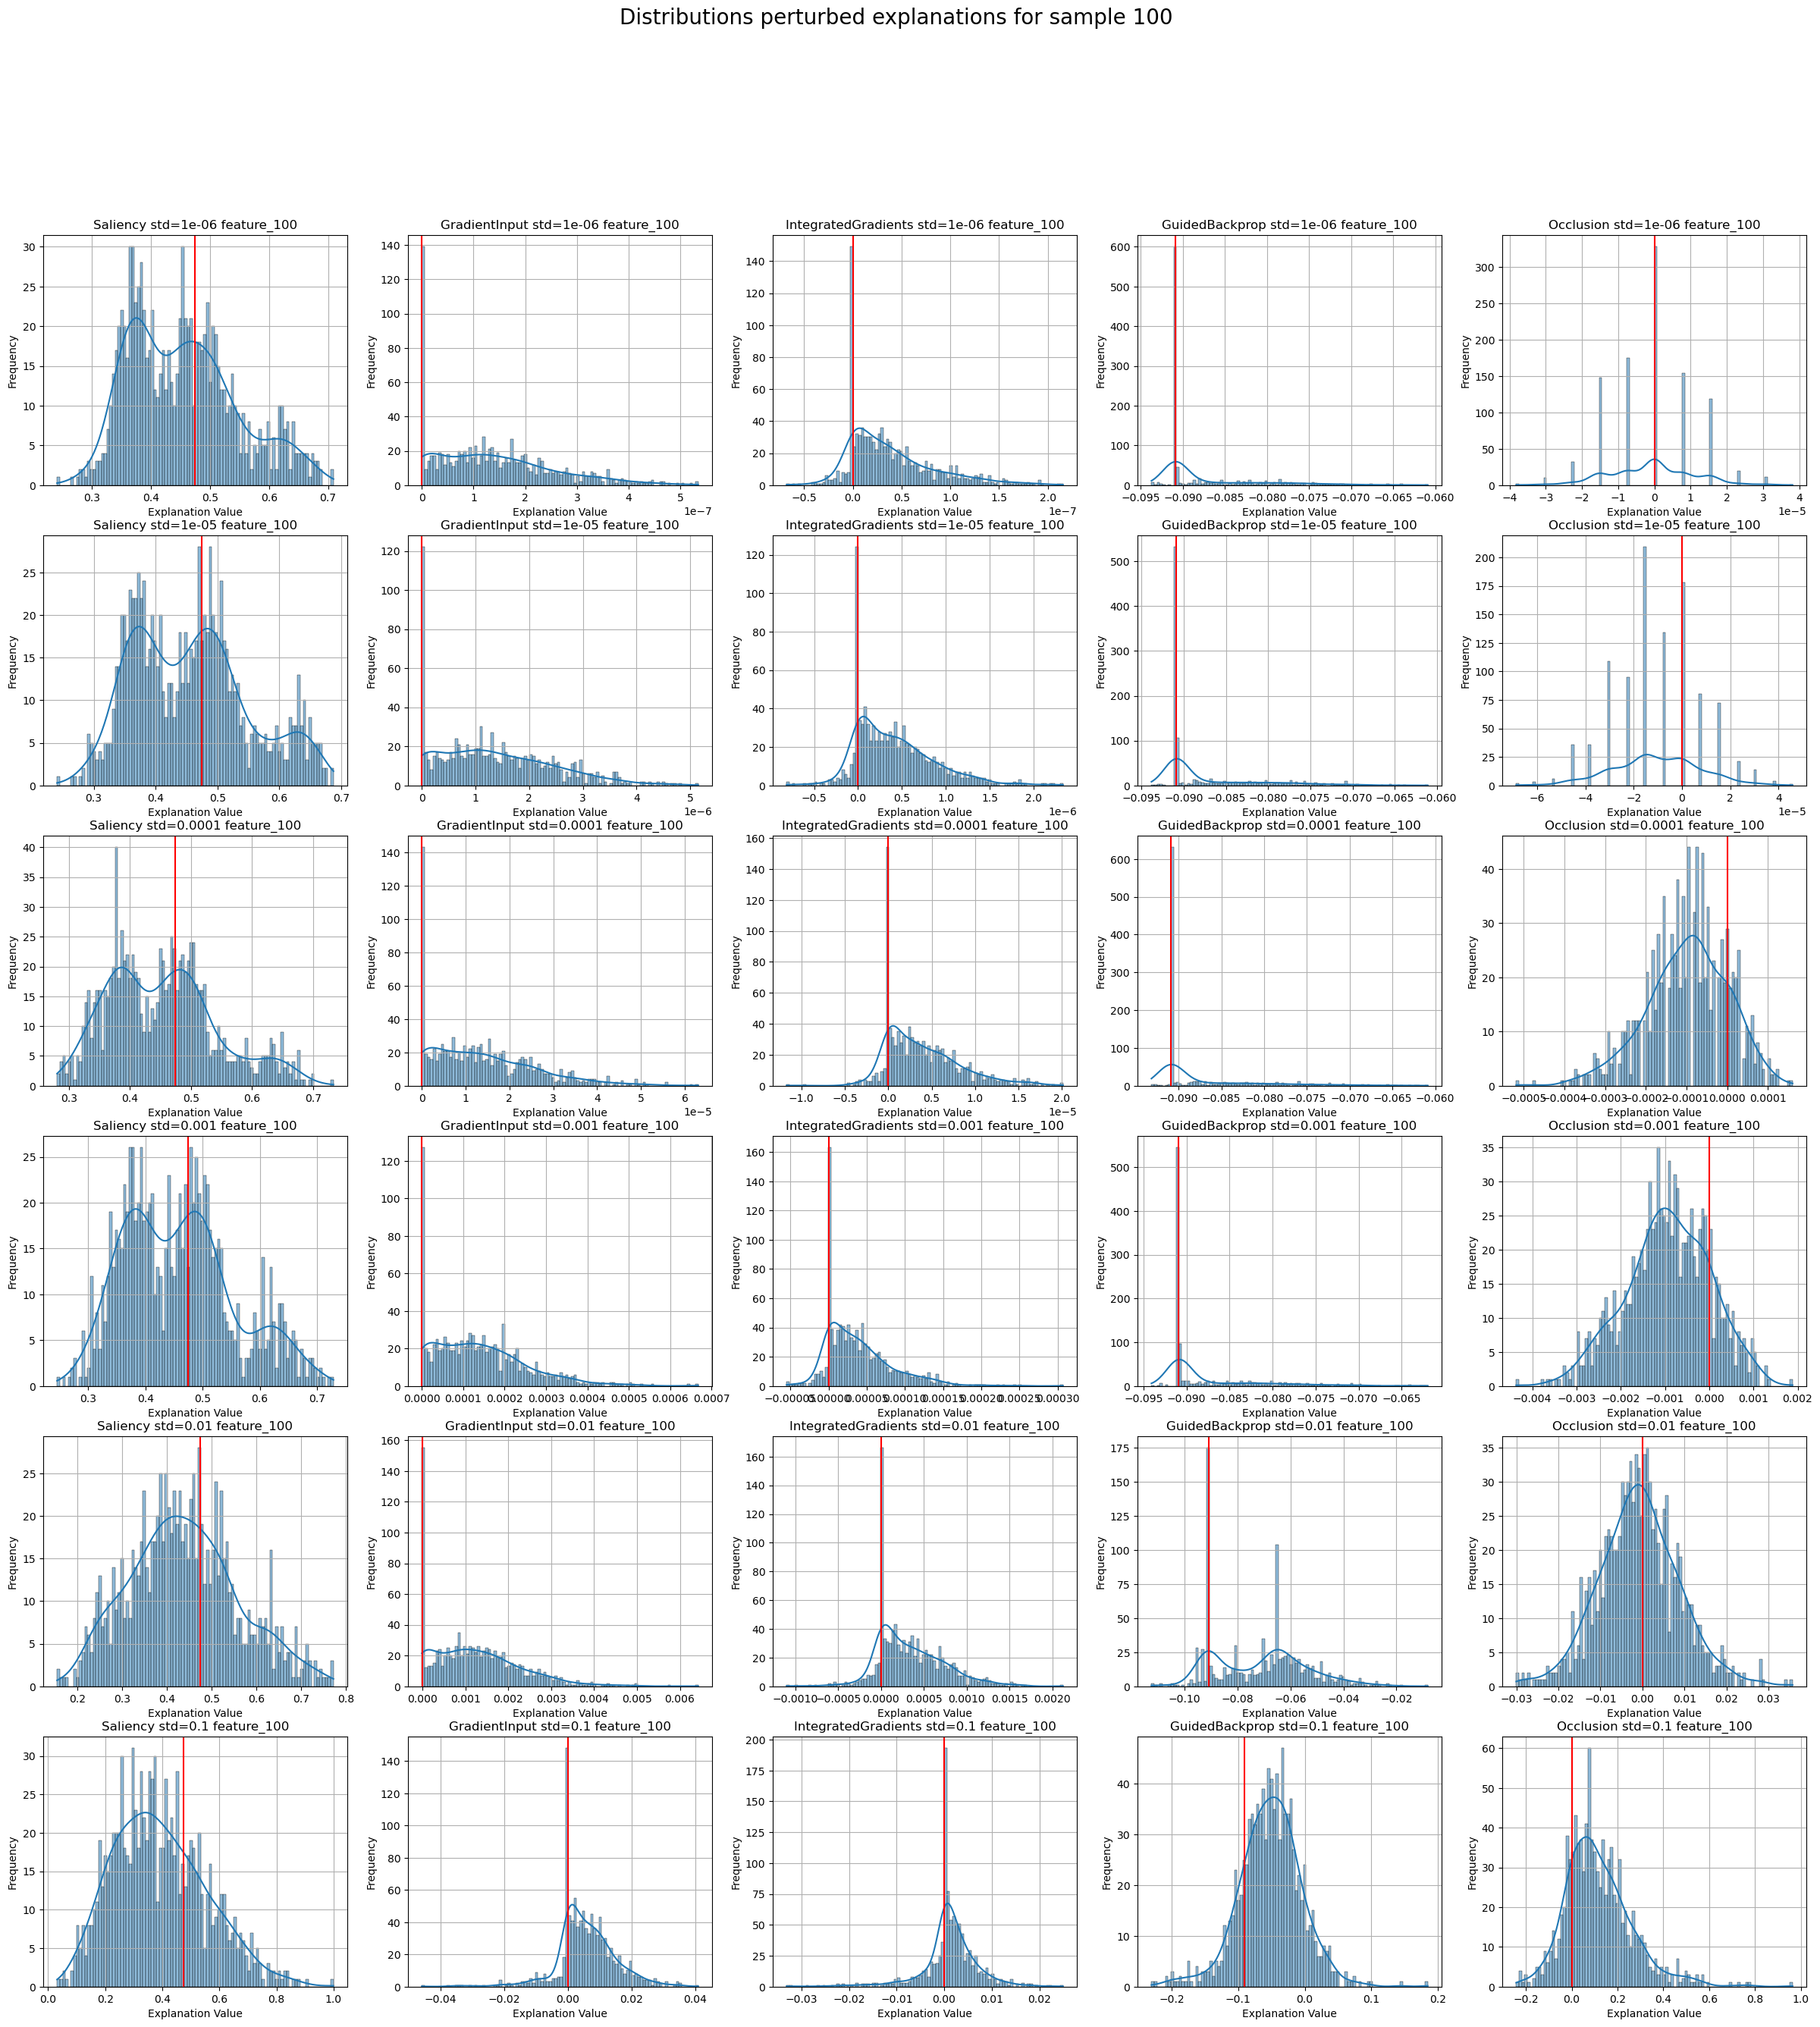

In [61]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 100, 100
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(empirical_exps[sample_id]): 
    for j, std in enumerate(stds):
        plt.subplot(6,5,5*j+i+1)
        sns.histplot(empirical_exps[sample_id][exp_name][std][:,feature_id], kde=True, bins=100)
        plt.axvline(x=unperturbed_exps[sample_id][exp_name][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ' std=' + str(std) + ' feature_' + str(feature_id))
        plt.xlabel("Explanation Value")
        plt.ylabel("Frequency")
        plt.grid()
plt.show()

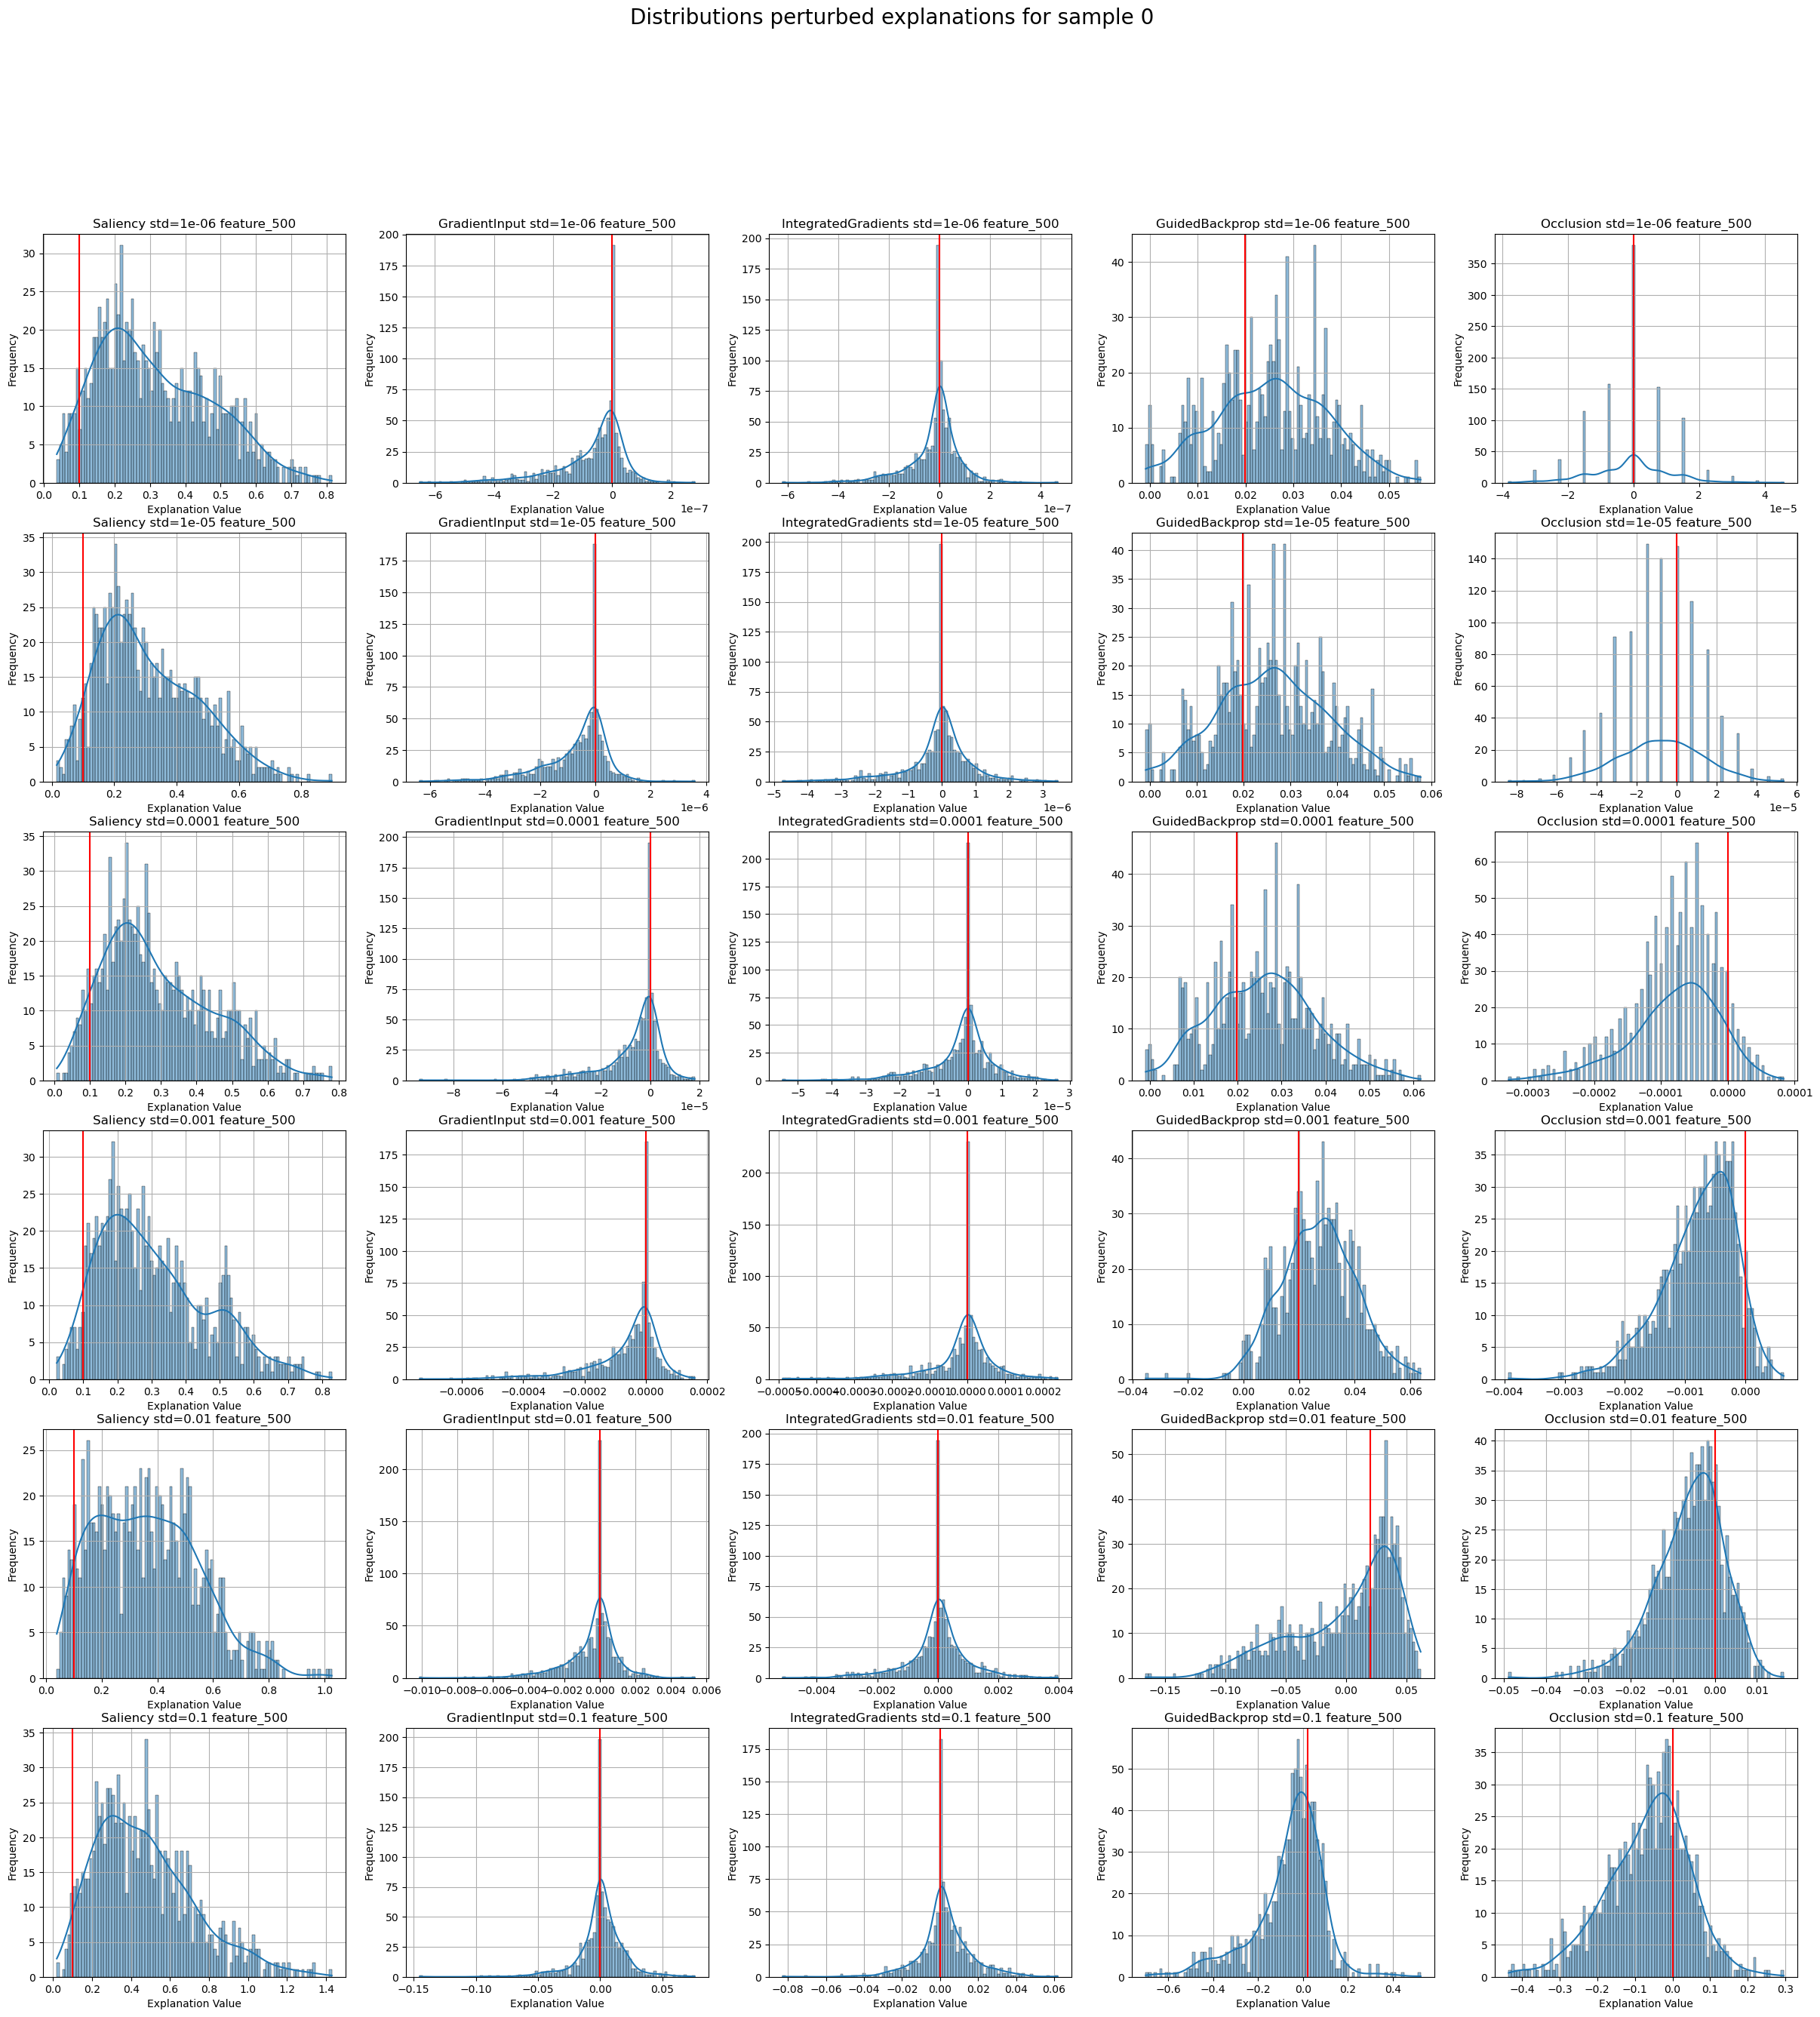

In [62]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 0, 500
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(empirical_exps[sample_id]): 
    for j, std in enumerate(stds):
        plt.subplot(6,5,5*j+i+1)
        sns.histplot(empirical_exps[sample_id][exp_name][std][:,feature_id], kde=True, bins=100)
        plt.axvline(x=unperturbed_exps[sample_id][exp_name][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ' std=' + str(std) + ' feature_' + str(feature_id))
        plt.xlabel("Explanation Value")
        plt.ylabel("Frequency")
        plt.grid()
plt.show()

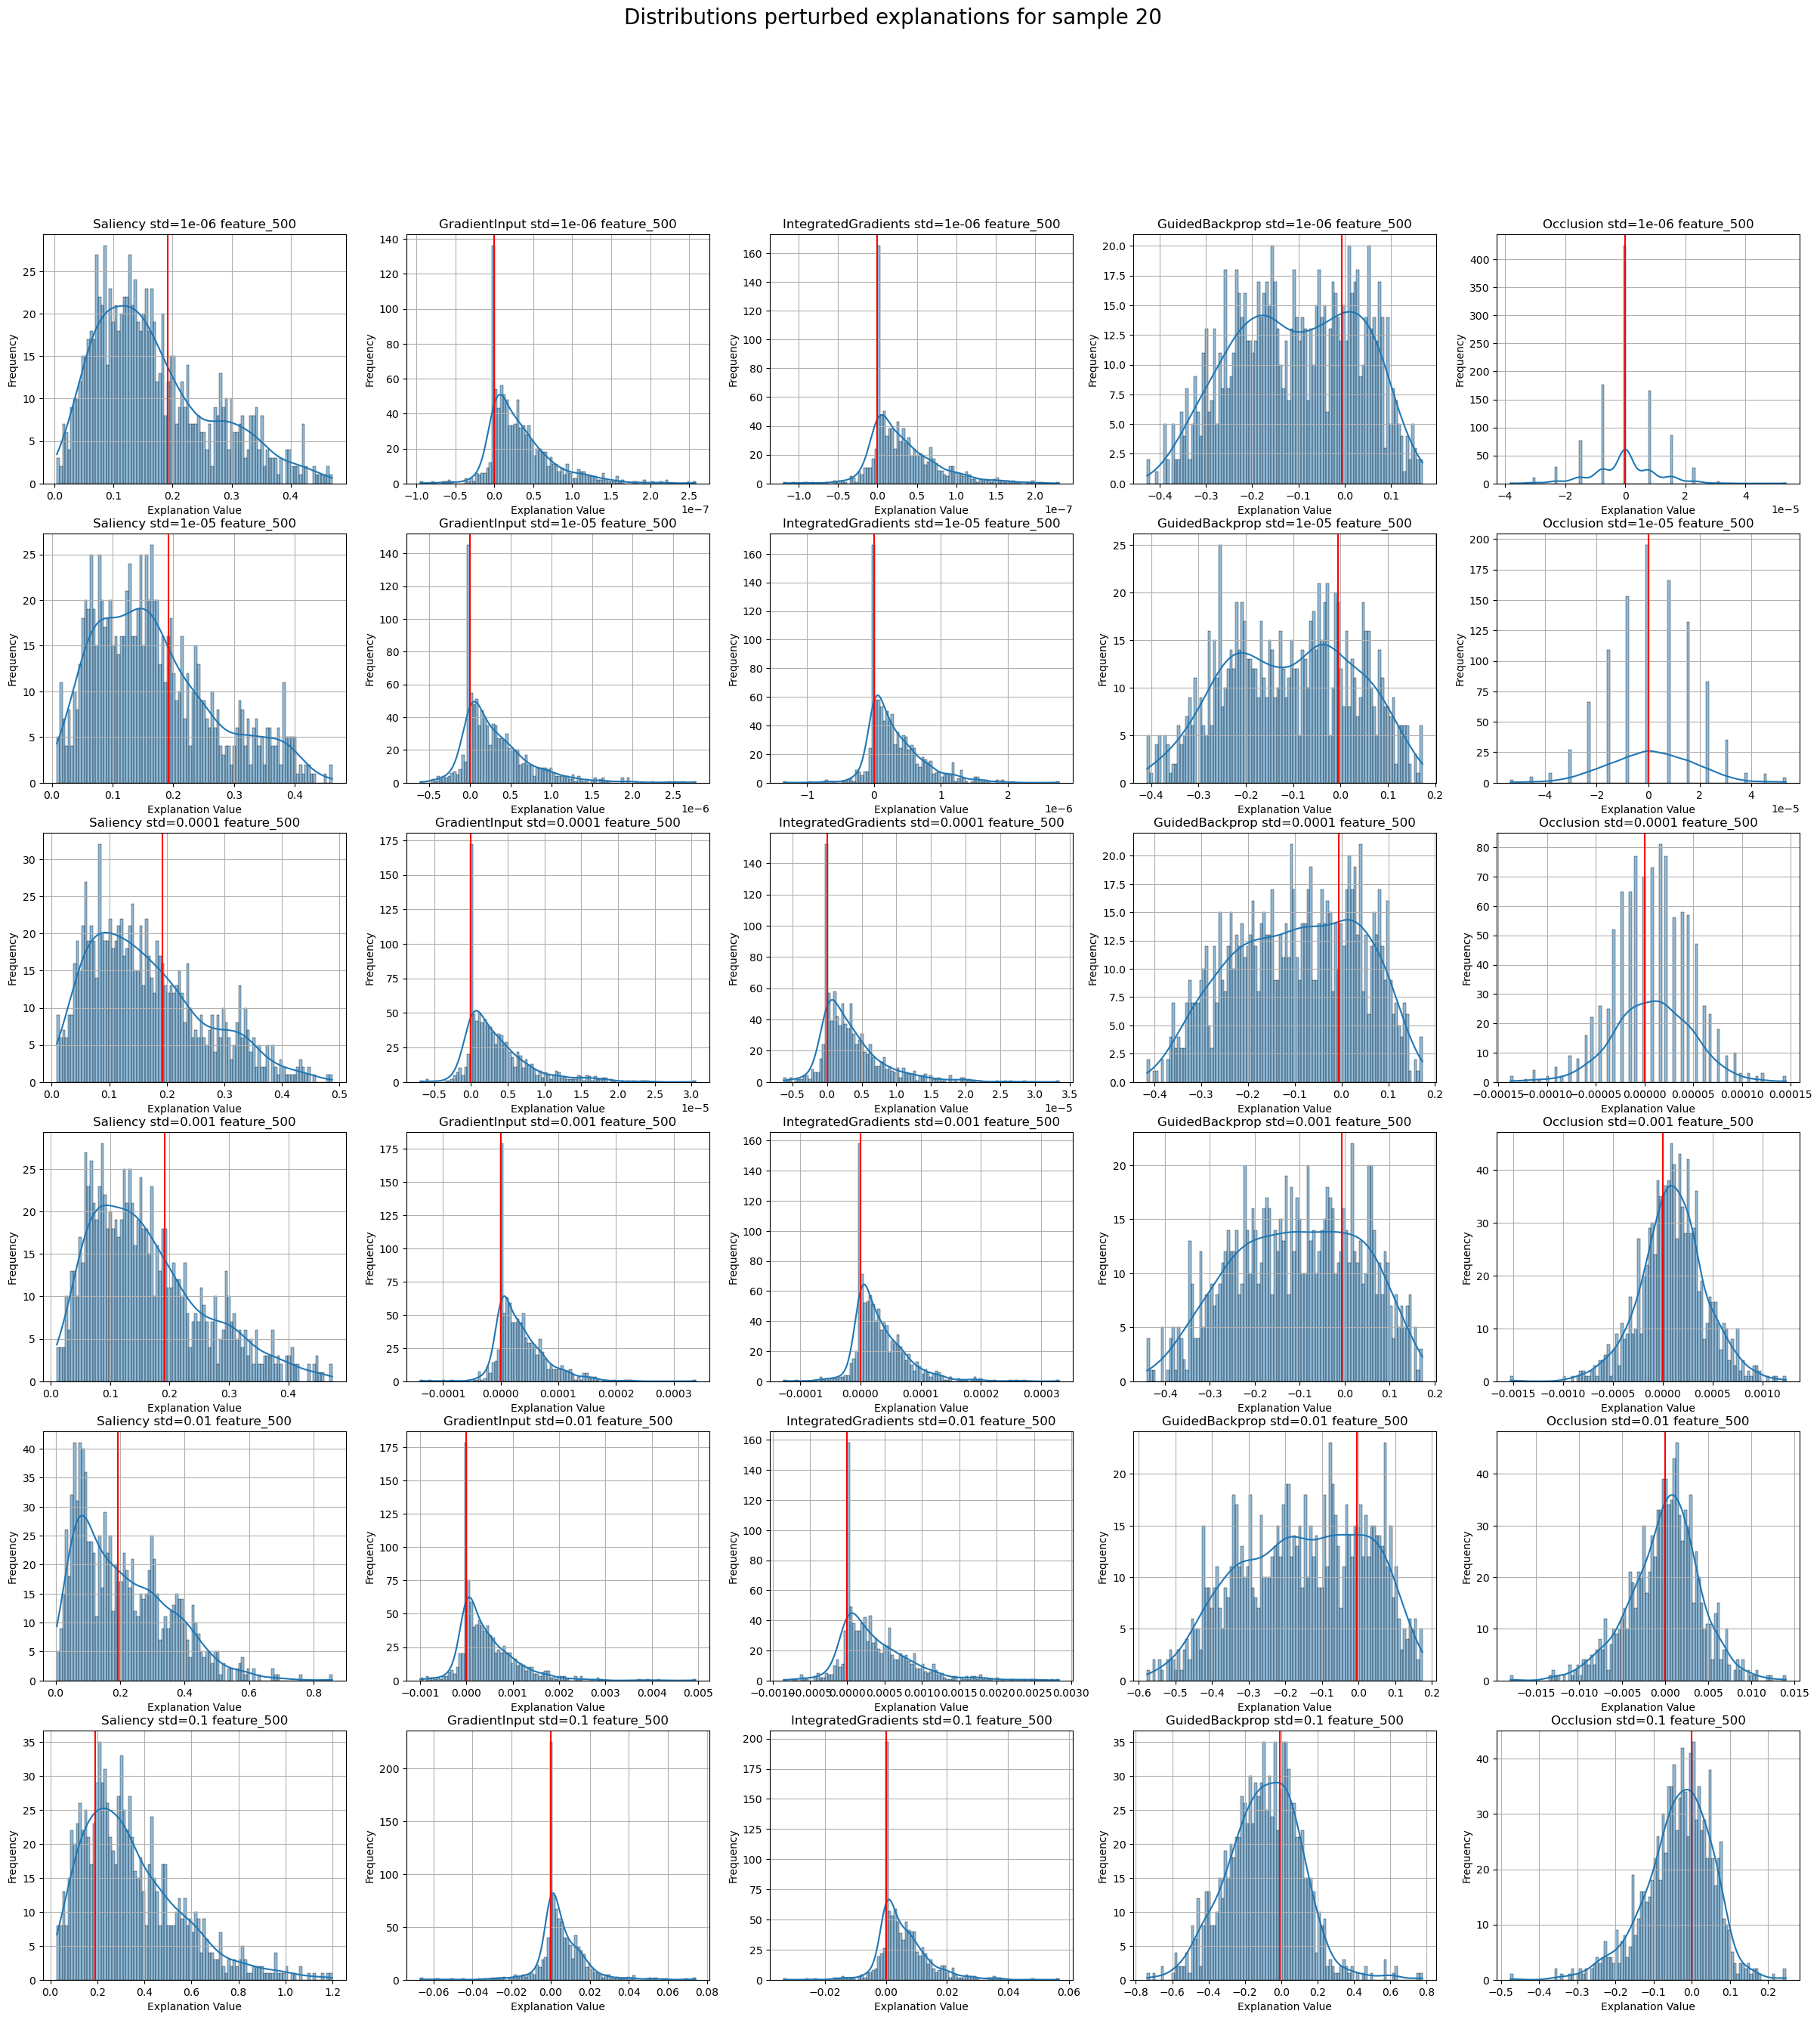

In [63]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 20, 500
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(empirical_exps[sample_id]): 
    for j, std in enumerate(stds):
        plt.subplot(6,5,5*j+i+1)
        sns.histplot(empirical_exps[sample_id][exp_name][std][:,feature_id], kde=True, bins=100)
        plt.axvline(x=unperturbed_exps[sample_id][exp_name][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ' std=' + str(std) + ' feature_' + str(feature_id))
        plt.xlabel("Explanation Value")
        plt.ylabel("Frequency")
        plt.grid()
plt.show()

c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\users\teo_c\anaconda3\envs\tf2_xplique\lib\site-packages\

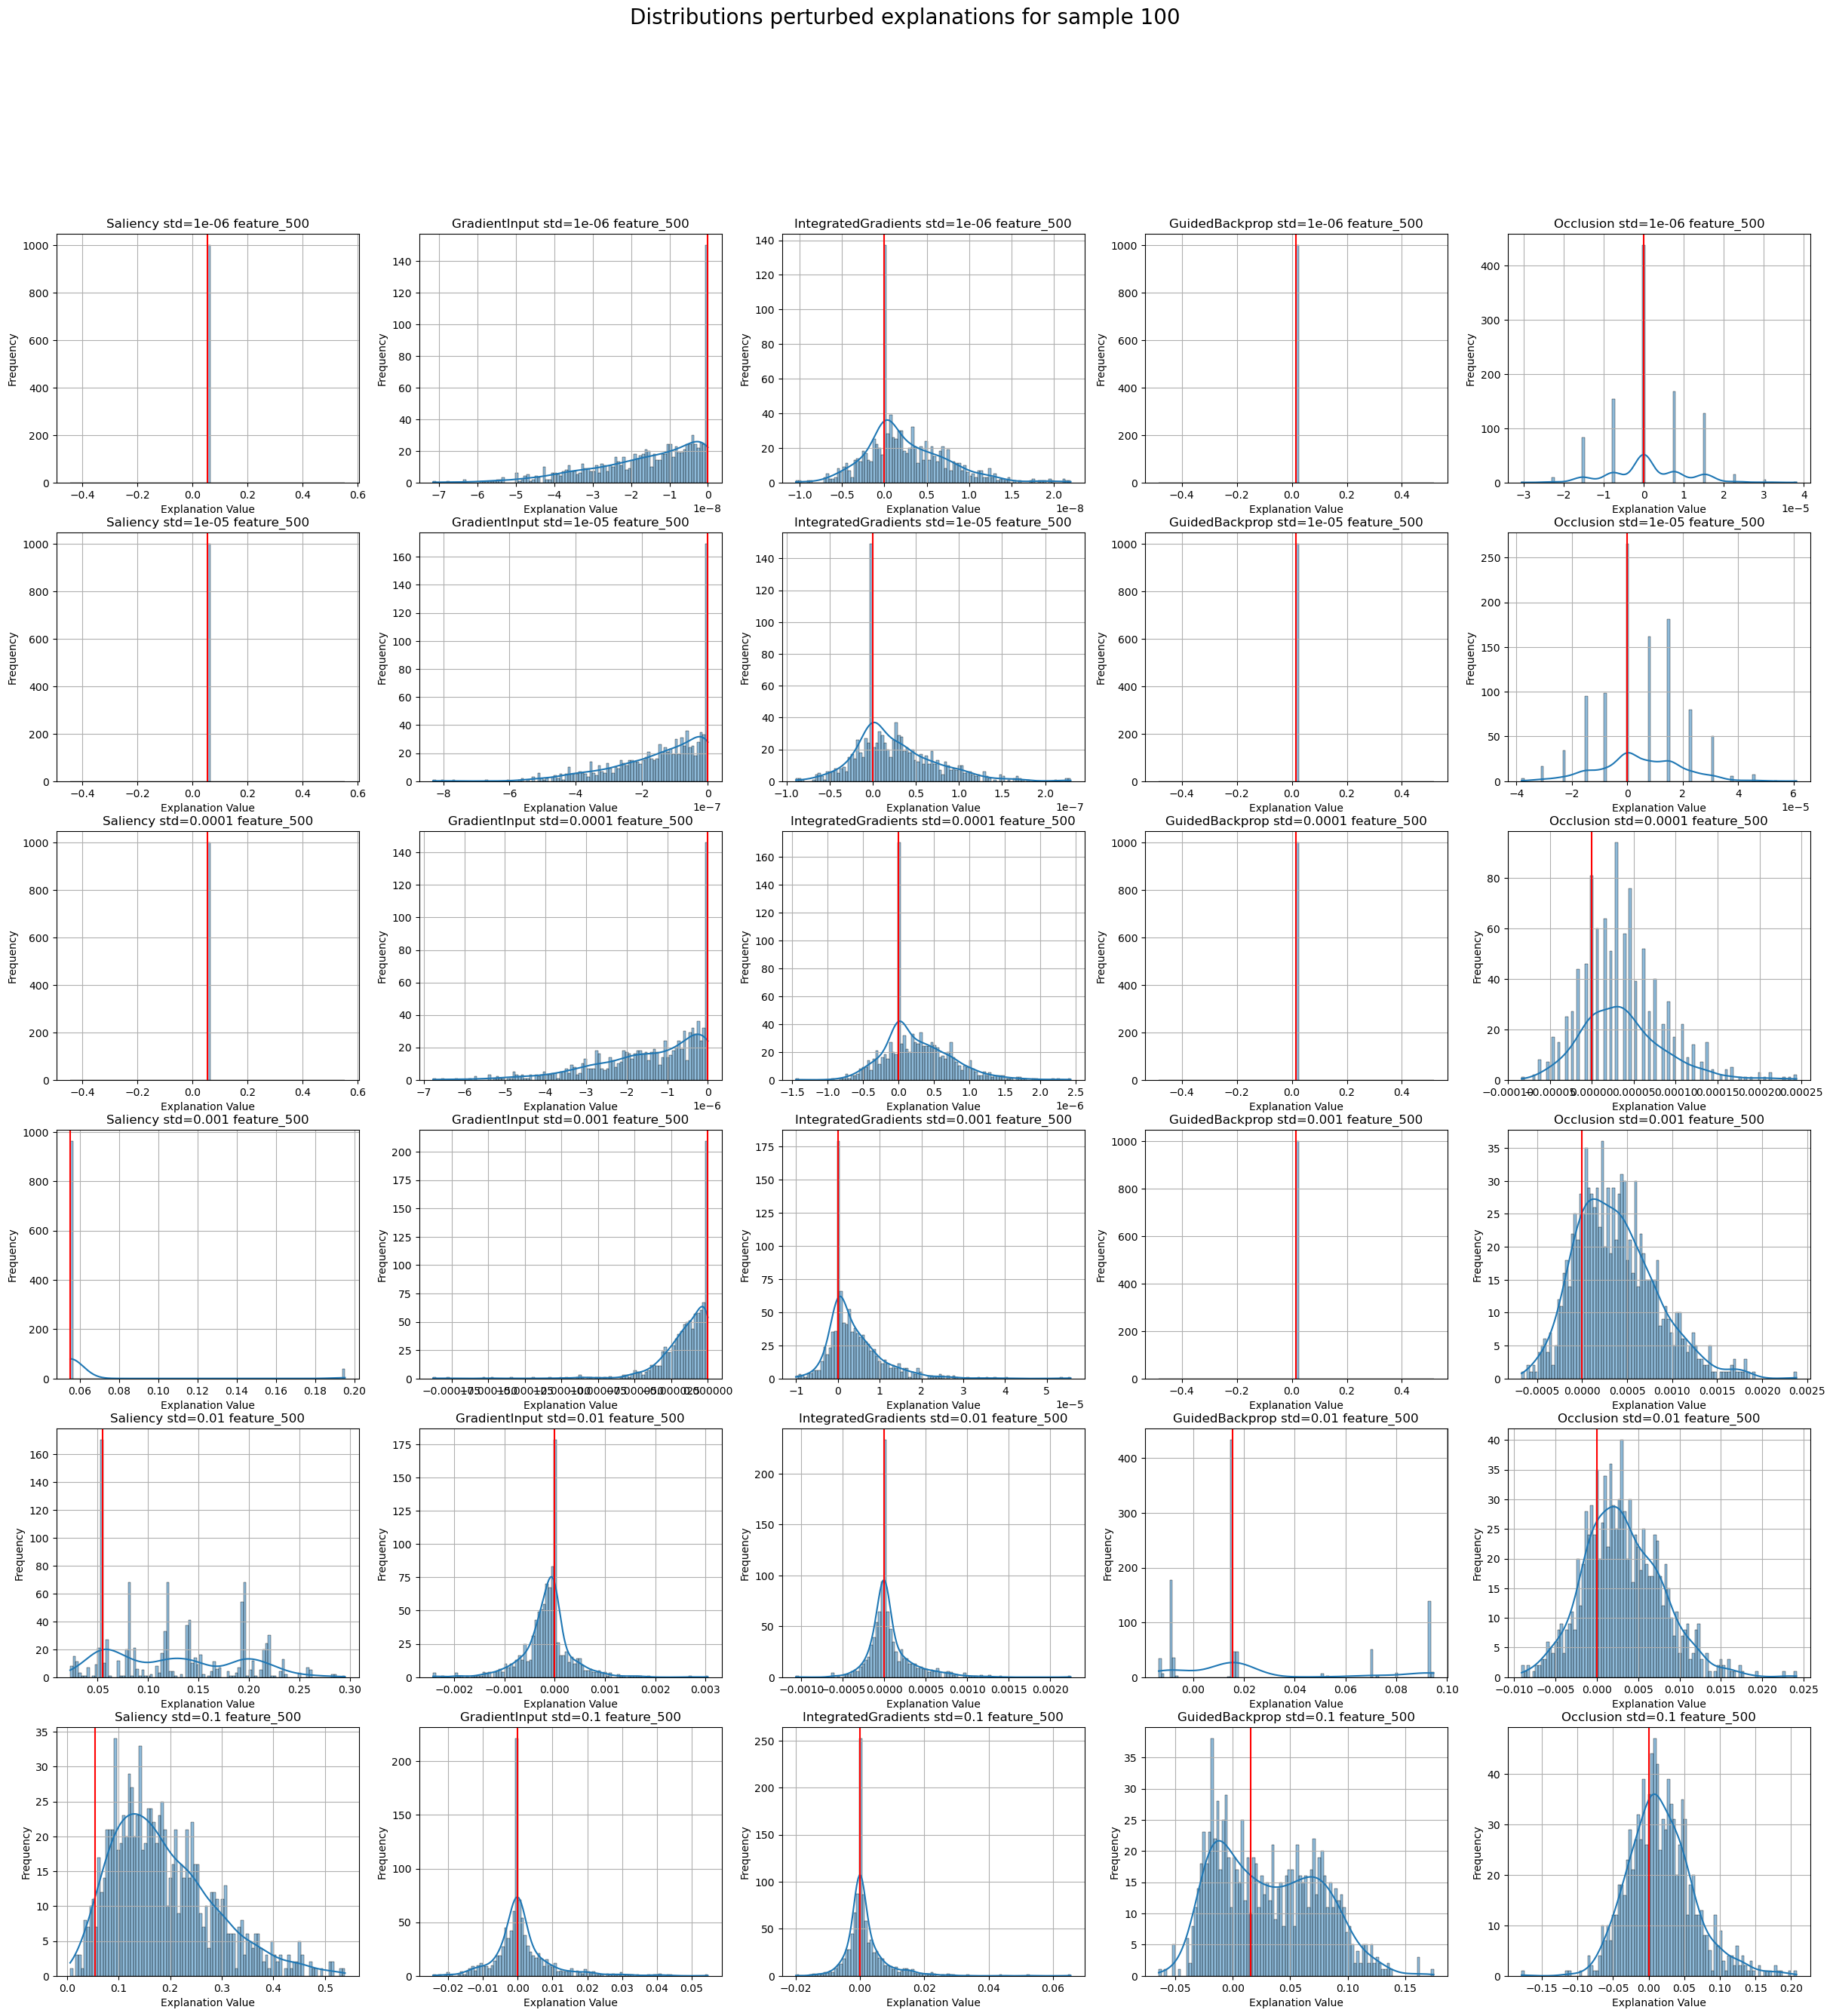

In [64]:
# Plot histogram and Kernel Density Estimate (KDE)
sample_id, feature_id = 100, 500
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Distributions perturbed explanations for sample ' + str(sample_id), fontsize=20)
for i, exp_name in enumerate(empirical_exps[sample_id]): 
    for j, std in enumerate(stds):
        plt.subplot(6,5,5*j+i+1)
        sns.histplot(empirical_exps[sample_id][exp_name][std][:,feature_id], kde=True, bins=100)
        plt.axvline(x=unperturbed_exps[sample_id][exp_name][feature_id], color='r')#, label='axvline - full height')
        plt.title(exp_name + ' std=' + str(std) + ' feature_' + str(feature_id))
        plt.xlabel("Explanation Value")
        plt.ylabel("Frequency")
        plt.grid()
plt.show()

C:\Users\teo_c\AppData\Local\Temp\ipykernel_3816\352958037.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0.0, 0.5])


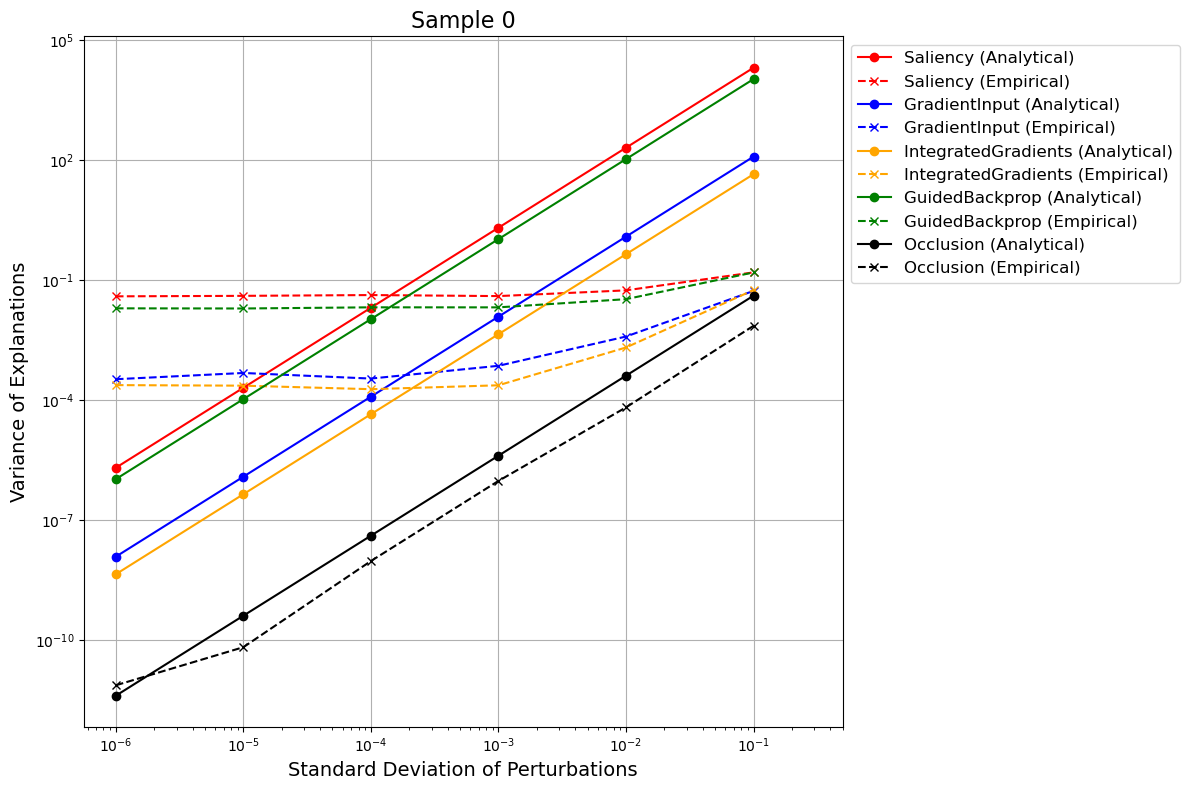

In [53]:
plt.figure(figsize=(12, 8))
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
for (name, data), col in zip(results[sample_id].items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed')

plt.xlabel('Standard Deviation of Perturbations', fontsize=14); plt.yscale('log')
plt.ylabel('Variance of Explanations', fontsize=14); plt.xscale('log')
plt.xlim([0.0, 0.5])
plt.title('Sample ' + str(sample_id), fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

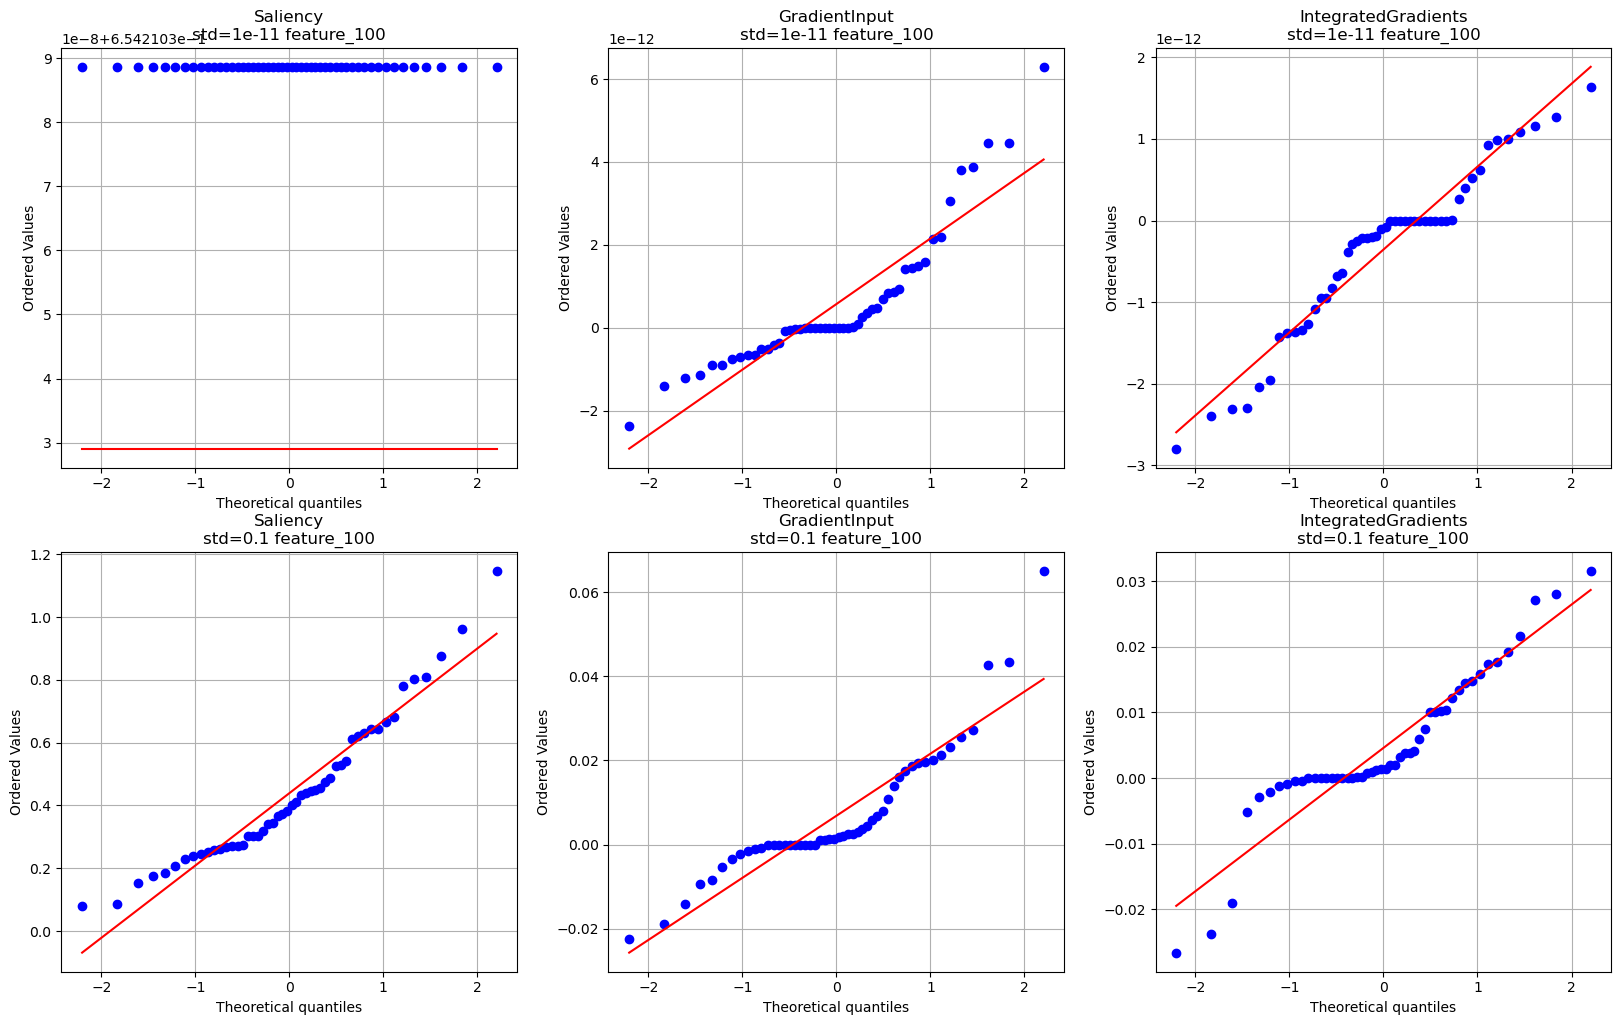

In [13]:
import scipy.stats as stats

# Generate Q-Q plot
plt.figure(figsize=(20, 12))
for i, exp_name in enumerate(empirical_exps): 
    for j, std in enumerate(stds):
        plt.subplot(2,3,3*j+i+1)
        stats.probplot(empirical_exps[exp_name][std][:,feature_id], dist="norm", plot=plt)
        plt.title(exp_name + '\nstd=' + str(std) + ' feature_' + str(feature_id))
        plt.grid()
plt.show()

In [14]:
from scipy.stats import ks_1samp, norm

for i, exp_name in enumerate(empirical_exps): 
    for std in stds:
        # Normalize data (mean 0, std 1) to compare with standard normal distribution
        flat_exp = empirical_exps[exp_name][std][:,feature_id]
        standardized_exp = (flat_exp - np.mean(flat_exp)) / np.std(flat_exp)

        # Perform K-S test
        stat, p_value = ks_1samp(standardized_exp, norm.cdf)
        print('\n' + exp_name + ' std=' + str(std) + ' feature_' + str(feature_id))
        print("Kolmogorov-Smirnov test statistic:", stat)
        print("p-value:", p_value)

        if p_value > 0.05:
            print("Fail to reject null hypothesis: Explanations may be normally distributed.")
        else:
            print("Reject null hypothesis: Explanations are not normally distributed.")


Saliency std=1e-11 feature_100
Kolmogorov-Smirnov test statistic: 0.8413447460685429
p-value: 2.934018384393366e-40
Reject null hypothesis: Explanations are not normally distributed.

Saliency std=0.1 feature_100
Kolmogorov-Smirnov test statistic: 0.1133952232977401
p-value: 0.5052324202308175
Fail to reject null hypothesis: Explanations may be normally distributed.

GradientInput std=1e-11 feature_100
Kolmogorov-Smirnov test statistic: 0.21319975773630823
p-value: 0.017909192813192143
Reject null hypothesis: Explanations are not normally distributed.

GradientInput std=0.1 feature_100
Kolmogorov-Smirnov test statistic: 0.20348358937347238
p-value: 0.027196955002980472
Reject null hypothesis: Explanations are not normally distributed.

IntegratedGradients std=1e-11 feature_100
Kolmogorov-Smirnov test statistic: 0.1683469865533498
p-value: 0.10441961014569734
Fail to reject null hypothesis: Explanations may be normally distributed.

IntegratedGradients std=0.1 feature_100
Kolmogorov-Sm

C:\Users\Teo\AppData\Local\Temp/ipykernel_28168/856171013.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0.0, 0.5])


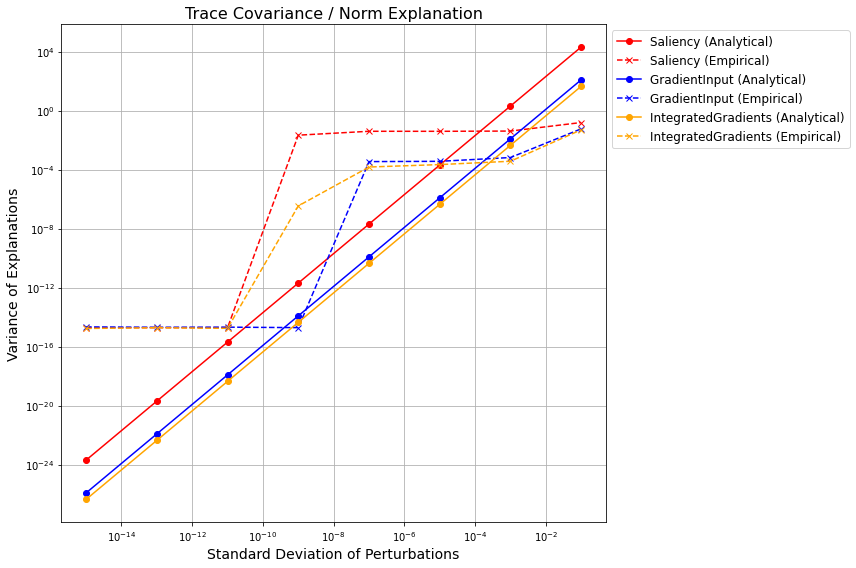

In [84]:
# Sample 0 ('7') - a few methods, a few sigmas
plt.figure(figsize=(12, 8))
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
for (name, data), col in zip(results.items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed')

plt.xlabel('Standard Deviation of Perturbations', fontsize=14); plt.yscale('log')
plt.ylabel('Variance of Explanations', fontsize=14); plt.xscale('log')
plt.xlim([0.0, 0.5])
plt.title('Trace Covariance / Norm Explanation', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

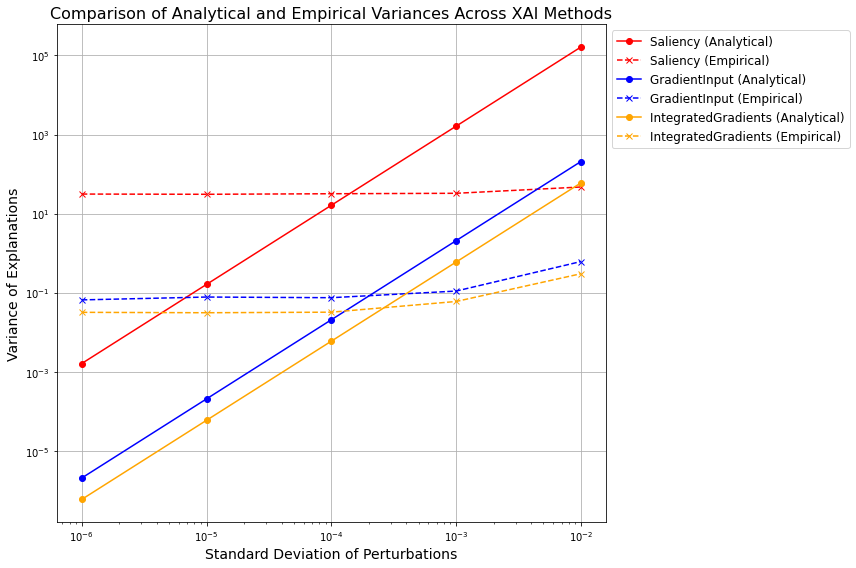

In [12]:
# Sample 0 ('7') - a few methods, a few sigmas
plt.figure(figsize=(12, 8))
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
for (name, data), col in zip(results.items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed')

plt.xlabel('Standard Deviation of Perturbations', fontsize=14); plt.yscale('log')
plt.ylabel('Variance of Explanations', fontsize=14); plt.xscale('log')
plt.title('Comparison of Analytical and Empirical Variances Across XAI Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

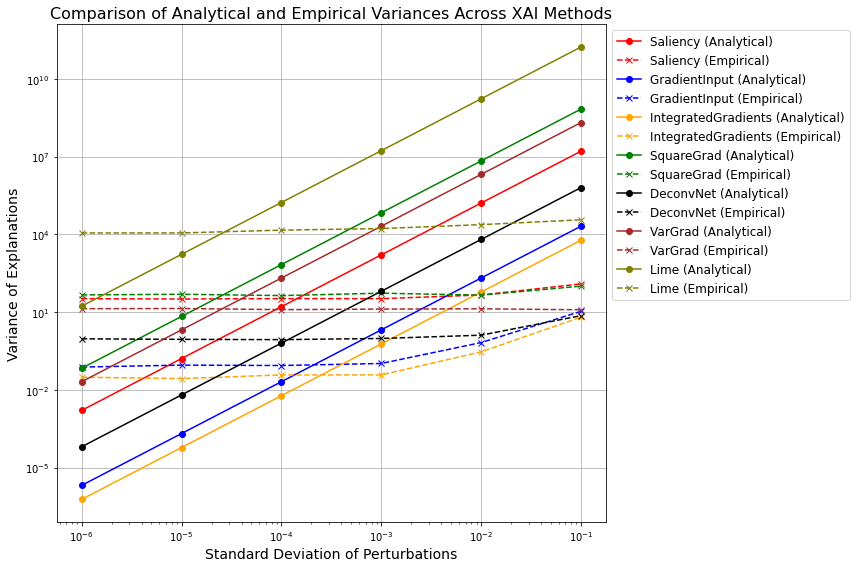

In [26]:
# Sample 0 ('7')
plt.figure(figsize=(12, 8))
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
for (name, data), col in zip(results.items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed')

plt.xlabel('Standard Deviation of Perturbations', fontsize=14); plt.yscale('log')
plt.ylabel('Variance of Explanations', fontsize=14); plt.xscale('log')
plt.title('Comparison of Analytical and Empirical Variances Across XAI Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

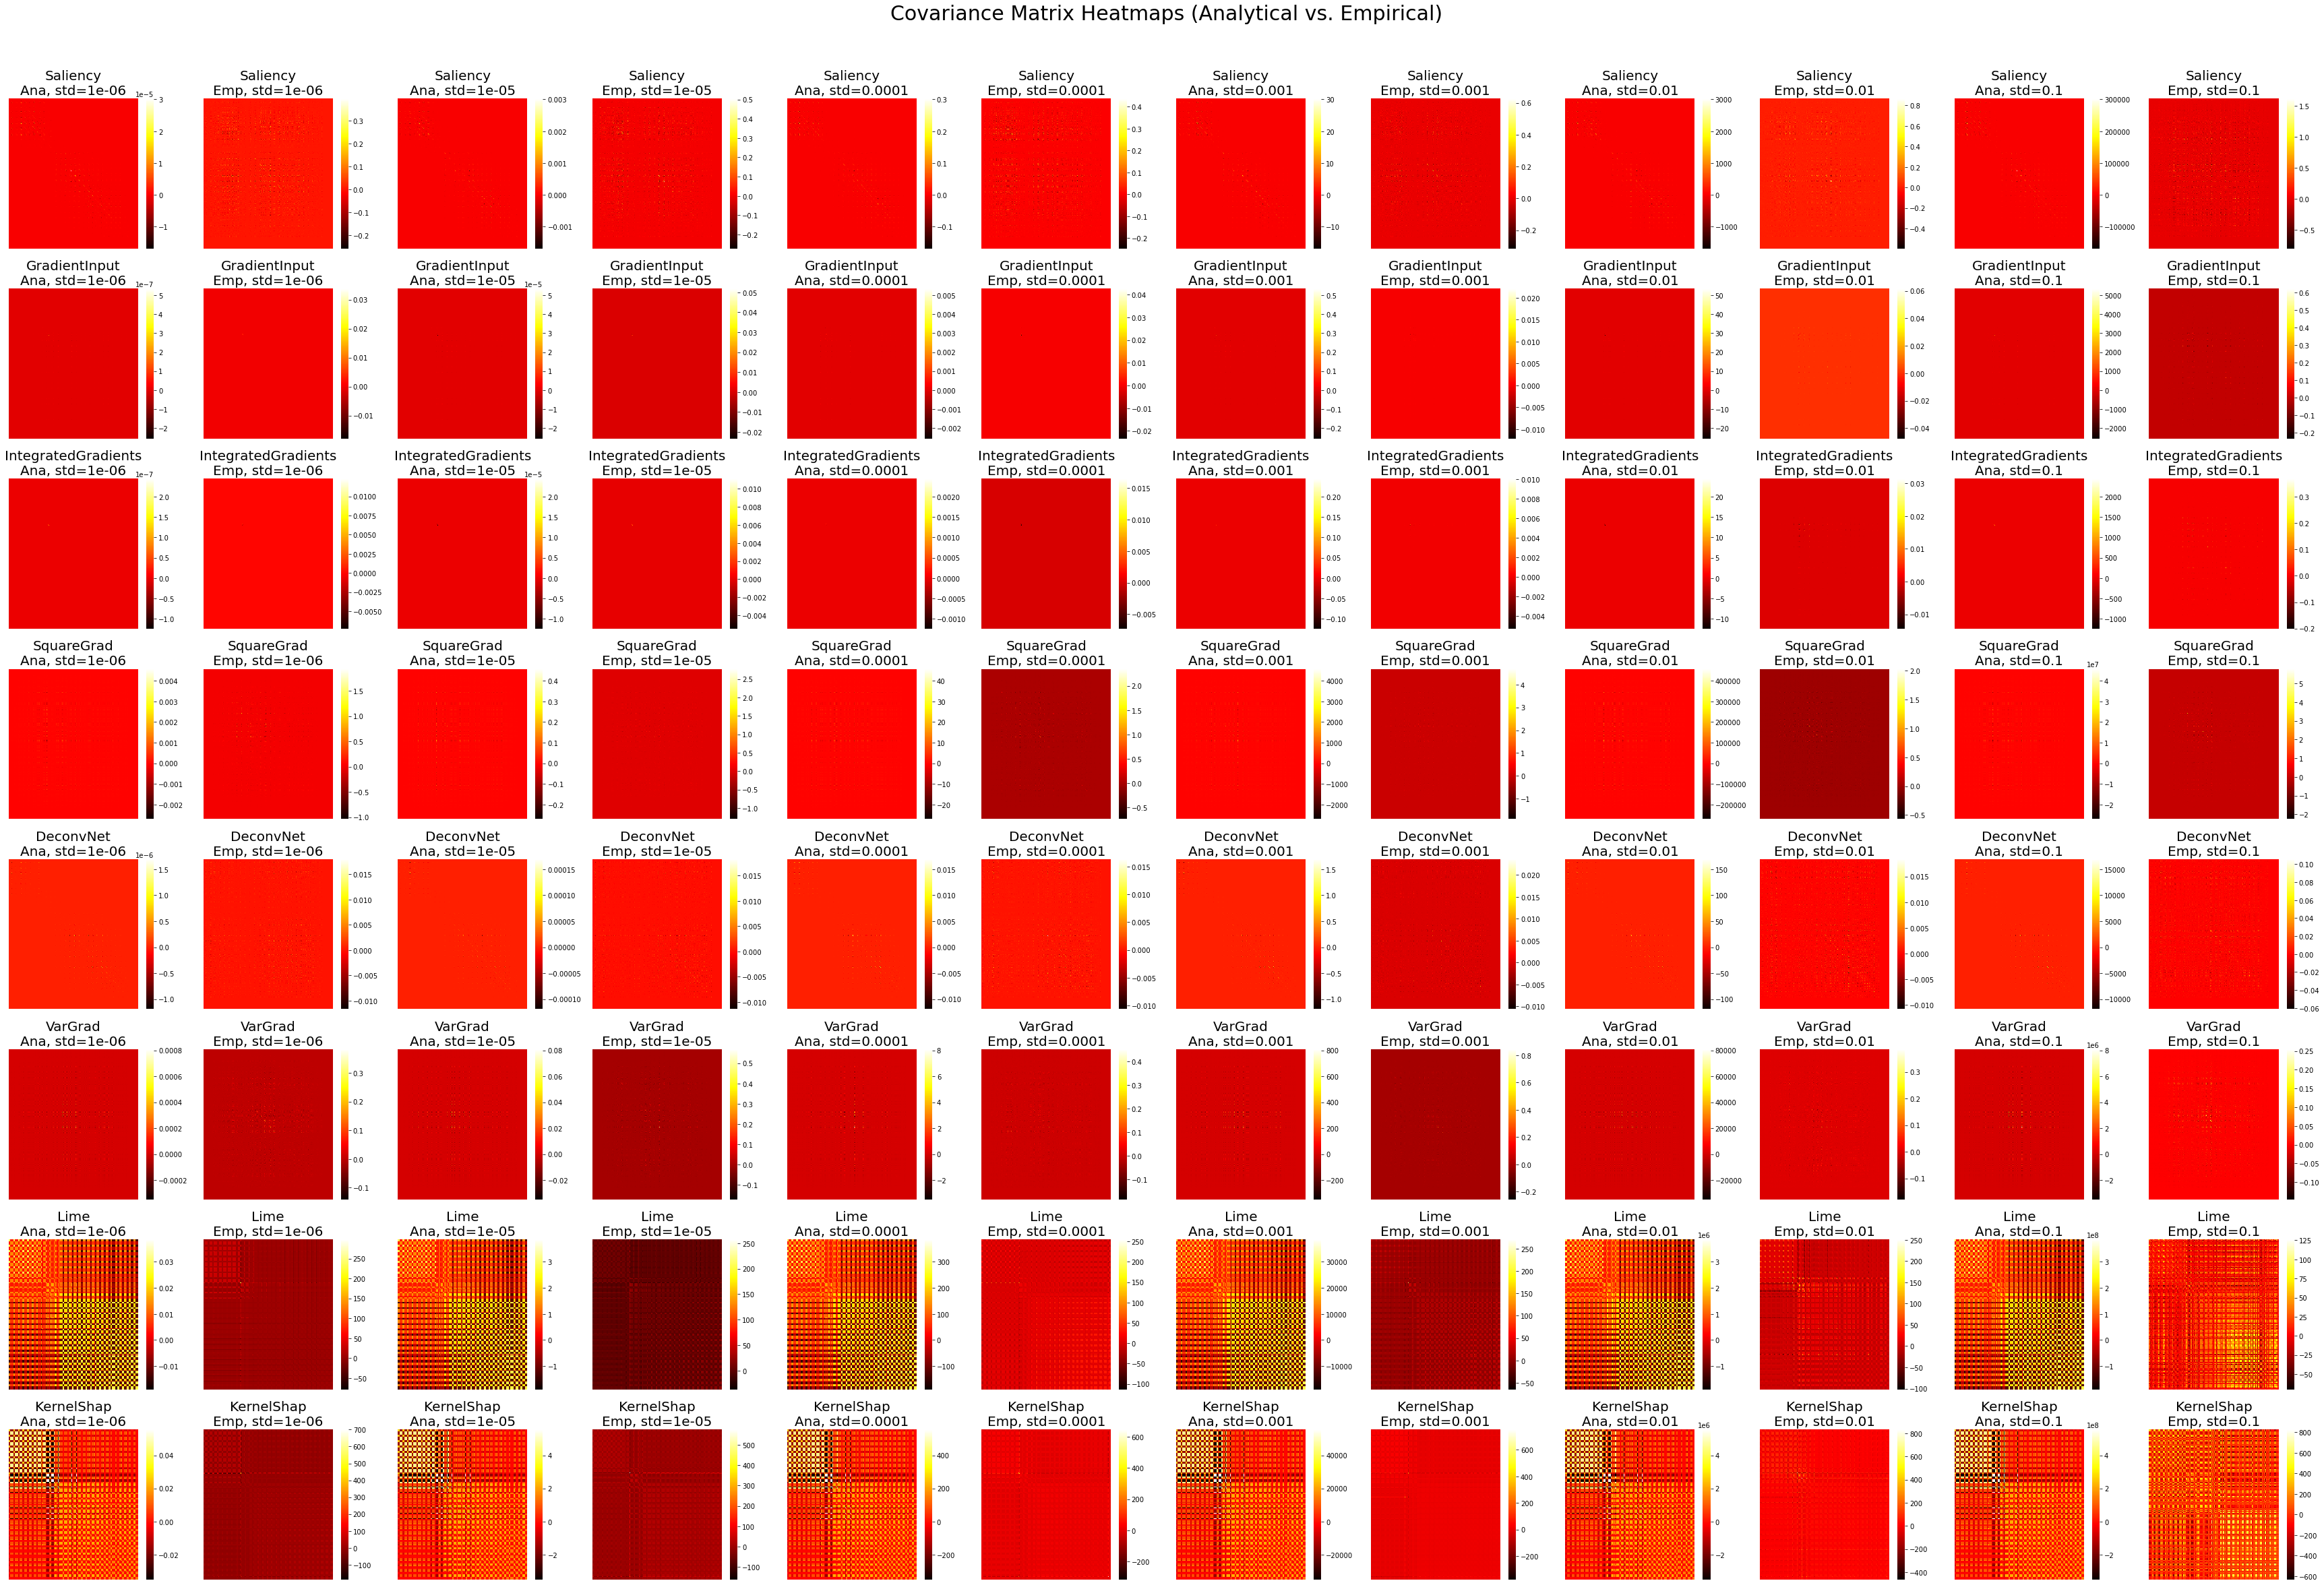

In [27]:
# Create heatmaps for all methods and perturbation stds
# Note: it may take 5 mins to display
def plot_heatmaps(cov_mats, stds):
    num_methods = len(cov_mats)
    num_stds = len(stds)

    fig, axes = plt.subplots(num_methods, num_stds * 2, figsize=(4 * num_stds * 2, 4 * num_methods))
    fig.suptitle('Covariance Matrix Heatmaps (Analytical vs. Empirical)', fontsize=30, y=1.02)

    for i, (name, cov_data) in enumerate(cov_mats.items()):
        for j, std in enumerate(stds):
            # Analytical covariance matrix
            cov_ana = cov_data['analytical'][j]
            ax = axes[i, j * 2]
            sns.heatmap(cov_ana, ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nAna, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

            # Empirical covariance matrix
            cov_emp = cov_data['empirical'][j]
            ax = axes[i, j * 2 + 1]
            sns.heatmap(cov_emp, ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nEmp, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function to generate heatmaps
plot_heatmaps(cov_mats, stds)

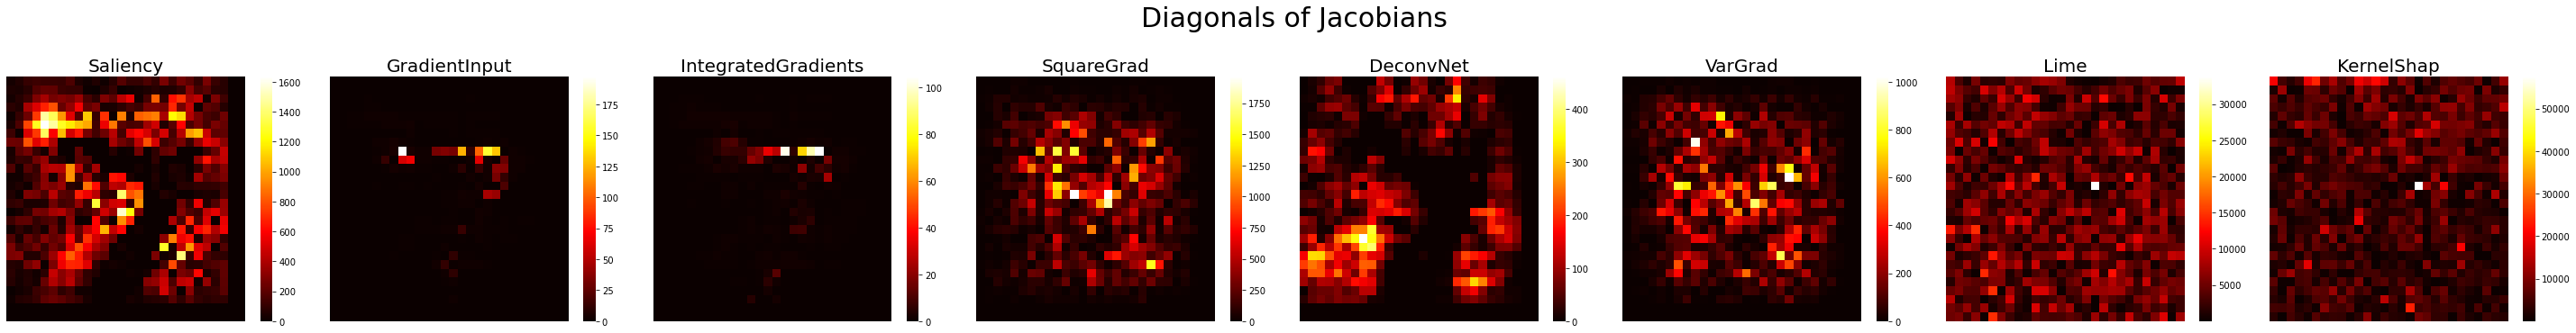

In [28]:
fig, axes = plt.subplots(1, len(jacobi_mats), figsize=(5*len(jacobi_mats), 5))
fig.suptitle('Diagonals of Jacobians', fontsize=30, y=1.02)

for i, (name, jmat) in enumerate(jacobi_mats.items()):
    ax = axes[i]
    sns.heatmap(np.abs(np.diag(jmat).reshape(h,w)), ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
    ax.set_title(f"{name}", fontsize=20)
    ax.tick_params(left=False, bottom=False)
plt.tight_layout()
plt.show()

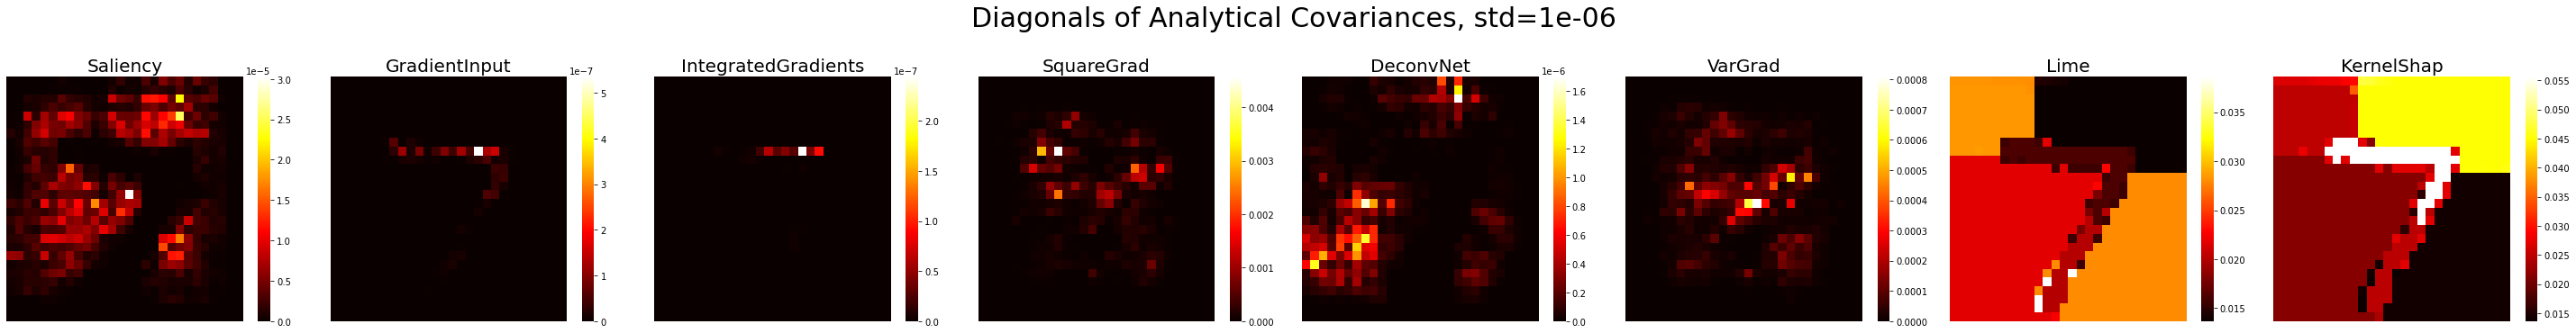

In [41]:
std_ind = 0
fig, axes = plt.subplots(1, len(cov_mats), figsize=(5*len(cov_mats), 5))
fig.suptitle(f'Diagonals of Analytical Covariances, std={stds[std_ind]}', fontsize=30, y=1.02)

for i, (name, cmat) in enumerate(cov_mats.items()):
    ax = axes[i]
    sns.heatmap(np.abs(np.diag(cmat['analytical'][std_ind]).reshape(h,w)), ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
    ax.set_title(f"{name}", fontsize=20)
    ax.tick_params(left=False, bottom=False)
plt.tight_layout()
plt.show()

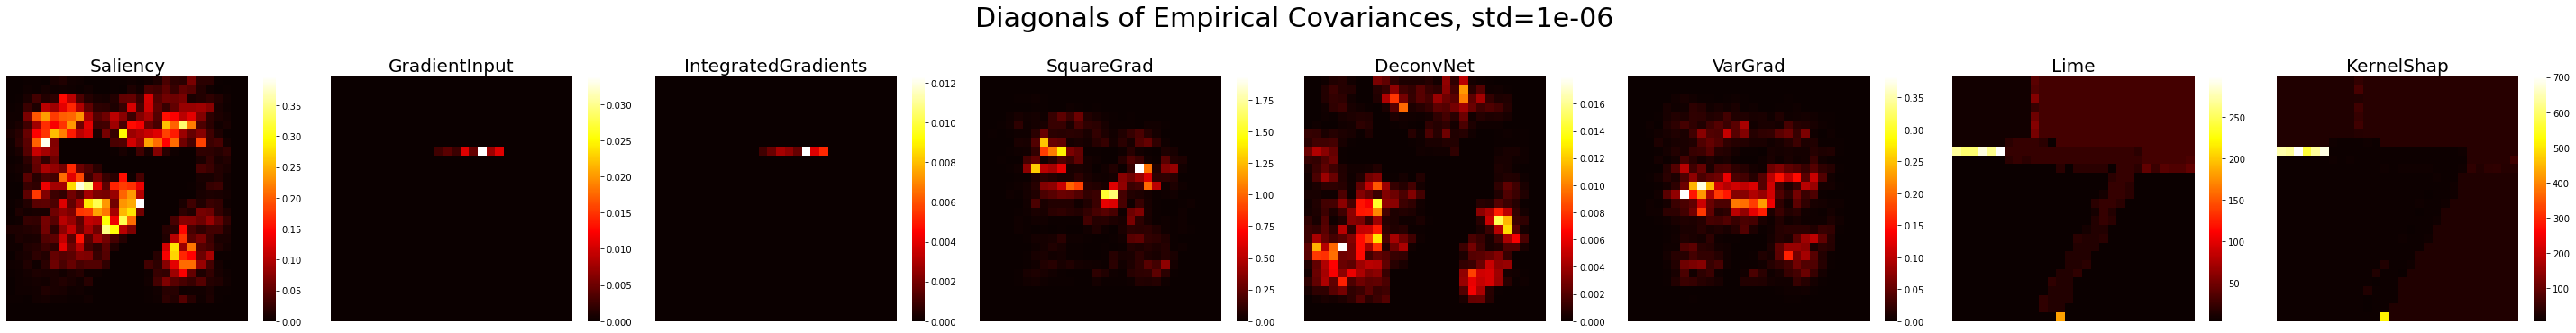

In [42]:
std_ind = 0
fig, axes = plt.subplots(1, len(cov_mats), figsize=(5*len(cov_mats), 5))
fig.suptitle(f'Diagonals of Empirical Covariances, std={stds[std_ind]}', fontsize=30, y=1.02)

for i, (name, cmat) in enumerate(cov_mats.items()):
    ax = axes[i]
    sns.heatmap(np.abs(np.diag(cmat['empirical'][std_ind]).reshape(h,w)), ax=ax, cmap="hot", xticklabels=False, yticklabels=False, cbar=True)
    ax.set_title(f"{name}", fontsize=20)
    ax.tick_params(left=False, bottom=False)
plt.tight_layout()
plt.show()

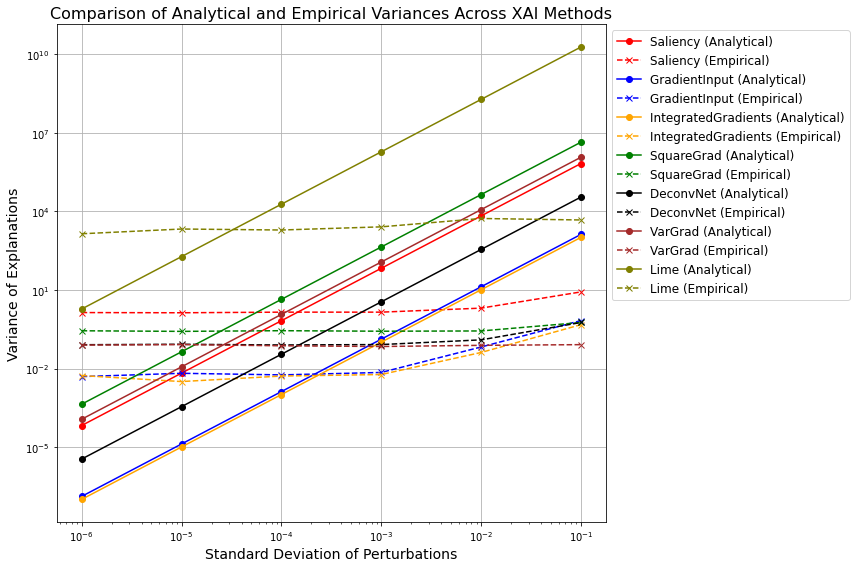

In [22]:
# Sample 1 ('2')
plt.figure(figsize=(12, 8))
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
for (name, data), col in zip(results.items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed')

plt.xlabel('Standard Deviation of Perturbations', fontsize=14); plt.yscale('log')
plt.ylabel('Variance of Explanations', fontsize=14); plt.xscale('log')
plt.title('Comparison of Analytical and Empirical Variances Across XAI Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()